In [34]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [35]:
import torch
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA TITAN RTX
__CUDA Device Total Memory [GB]: 25.388515328


In [36]:
!hostname

tikgpu05


In [37]:
import os
os.system("hostname")


tikgpu05


0

Load Data

In [ ]:
df = pd.read_csv('data/dataset_full_pre_text.csv')
del df['Link']
del df['Bookshelf']
df = df.dropna(subset=['Author', 'Text'])
df


In [ ]:
df = df.dropna(subset=['Author', 'Text'])
df.shape

In [ ]:
df = df.reset_index(drop=True)
df

In [ ]:
df__ = df.drop_duplicates(subset=['Author'], keep='first')
df__.shape
df__

Basic Dataset Information:

Author to Index Mapping

Author Counts: How many books does an Author have

Lengths of Encoded Author Names: Using gpt-4 and gpt2 tokenizers

In [ ]:
itoa = df__.set_index(df__.index)['Author'].to_dict()
itoa
atoi = dict(zip(df__['Author'], df__.index))
itoa

In [ ]:
author_counts = df['Author'].value_counts()
author_counts.sort_values(ascending=False, inplace=True)
print(min(author_counts), max(author_counts), author_counts.mean())
print((author_counts.unique()))
count_freq = author_counts.value_counts().sort_index()
count_freq.plot(kind='bar', label=False, figsize=(15, 5))
plt.ylabel('Number of Authors')
plt.title('Distribution of Author Occurrence Counts')

plt.show()


length of encoded authors

In [ ]:
import tiktoken
enc = tiktoken.encoding_for_model('gpt-4')
enc_2 = tiktoken.get_encoding("gpt2")
enc.encode('13655')

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
len(df.loc[:, 'Author'].values)
authors = df.loc[:, 'Author'].values
authors = [str(author) for author in authors]
authors_enc = [enc.encode(author) for author in authors]
authors_enc_len = [len(author) for author in authors_enc]
min_, max_ = min(authors_enc_len), max(authors_enc_len)
print(min_, max_)
print(set(authors_enc_len))
print(Counter(authors_enc_len))
plt.figure(figsize=(10, 6))
plt.hist(authors_enc_len, bins=range(min_, max_ + 1), edgecolor='black')
plt.title('Distribution of Encoded Author Name Lengths')
plt.xlabel('Length of Encoded Author Names')
plt.ylabel('Frequency')
plt.show()

In [ ]:
enc.special_tokens_set

In [ ]:
enc.eot_token

In [ ]:
enc._special_tokens
eop_token = 100276

Tokenization Methods/Testing of Dataframe

1.  Use index as ID of Author, store as Dataframe (list of lists). Each list corresponds to a row in the dataframe
2.  Use Author name as ID of Author, store as Dataframe (list of lists). 

Storing as a Dataframe, prevents model from training on cross-book samples.

Actual preprocessing of whole dataframe in data_preprocessing_2.py

In [ ]:
import torch

def tokenize_row(author, text):
    index = atoi[author]
    tokenized_index = enc.encode(str(index))
    tokenized_text = enc.encode(str(text))
    full_sequence = tokenized_index + [eop_token] + tokenized_text + [enc.eot_token]
    return torch.tensor(full_sequence, dtype=torch.long)

# Function to process the dataframe in chunks
def process_in_chunks(df, chunk_size=1000):
    tensor_list = []
    for start in range(0, len(df), chunk_size):
        end = min(start + chunk_size, len(df))  # Ensure we don't go out of bounds
        chunk = df.iloc[start:end]
        
        # Apply tokenization in the current chunk
        chunk_tensors = chunk.apply(lambda row: tokenize_row(row['Author'], row["Text"]), axis=1).tolist()
        tensor_list.extend(chunk_tensors)
        print(start)
    return tensor_list

# Process the dataframe in chunks
#tensor_list = process_in_chunks(df, chunk_size=1000)
#print(f"Number of tensors: {len(tensor_list)}")


In [ ]:
def tokenize_row(author, text):
    index = atoi[author]
    tokenized_index = enc.encode(str(index))
    tokenized_text = enc.encode(str(text))
    full_sequence = tokenized_index + [eop_token] + tokenized_text + [enc.eot_token]
    return torch.tensor(full_sequence, dtype=torch.long)

# Apply tokenization and convert to tensors
#df.loc[:,"tokenized_tensor"] = df.apply(lambda row: tokenize_row(row['Author'], row["Text"]), axis=1)
# Convert to a list of tensors
#tensor_list = df["tokenized_tensor"].tolist()
#len(tensor_list)
"""flattened_np = np.concatenate([tensor.numpy() for tensor in tensor_list])
flattened_np
offsets = np.cumsum([0] + [t.shape[0] for t in tensor_list[:-1]])
offsets
filename = "tensor_memmap.dat"
arr = np.memmap(filename, dtype=np.float32, mode='w+', shape=(len(flattened_np),))
arr[:] = flattened_np[:]
arr.flush()
np.save("tensor_offsets.npy", offsets)"""

Loading preprocessed Data.

List of Lists

1. Data_author_indices.bin --> Index = Author ID
2. Data_author_names.bin --> Name = Author ID

In [ ]:

arr = np.memmap("data/data_author_indices.bin", dtype=np.float32, mode='r')
offsets = np.load("data/author_indices_offsets.npy")
indices_tensor = [arr[offsets[i]:offsets[i+1]] for i in range(len(offsets)-1)]
len(indices_tensor)
len(offsets)
indices_tensor[:2]

In [ ]:
from sklearn.model_selection import train_test_split
train_memmap, test_memmap = train_test_split(indices_tensor, test_size=0.005, random_state=42)

# Print results
print(f"Train set size: {len(train_memmap)}")
print(f"Test set size: {len(test_memmap)}")

In [ ]:
train_memmap[:10]

Loading Functions test

get_batch_tensor incooperates the fixed use of the first index of each sample. Model is always confronted with the first token

In [ ]:
ix = torch.randint(len(offsets), (1,))
print(ix)
print(indices_tensor[ix])
type(torch.tensor(indices_tensor[ix]))
data = (indices_tensor[ix])
block_size = 8
batch_size = 2
ix = torch.randint(1, len(data) - block_size-1, (batch_size,))
ix = np.concatenate(([0], ix))
x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])

print(ix)
print(0 in ix)
print('x')
print(x)
print('y')
print(y)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_batch_tensor(split):
    if split=='train':
        data = train_memmap
    else:
        data = test_memmap
    ix = torch.randint(len(data), (1,))
    data = data[ix]
    if len(data) < block_size:
        data = np.concatenate(( np.zeros(block_size - len(data) +3), data))
    ix = torch.randint(1, len(data) - block_size-1, (batch_size-1,))
    ix = np.concatenate(([0], ix))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device=='cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x,y
def get_batch_tensor_testing(split):
    if split=='train':
        data = train_memmap
    else:
        data = test_memmap
    ix = torch.randint(len(data), (1,))
    data = data[ix]
    ix = torch.randint(1, len(data) - block_size-1, (batch_size-1,))
    ix = np.concatenate(([0], ix))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+block_size:min(i+2*block_size, len(data))]).astype(np.int64)) for i in ix])
    if device=='cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x,y
type(get_batch_tensor('val')[0])

In [ ]:
enc.decode(x[0].tolist())
itoa[5213]

Remaking Training and Testing Dataframes for easier use during backtesting

In [ ]:
enc.decode(test_memmap[0].astype(np.int64).tolist())

In [ ]:
len(test_memmap)

In [ ]:
at_tuples = []
def split_for_df(token_list):
    token_list = token_list.astype(np.int64).tolist()
    index = token_list.index(eop_token)
    author_index = token_list[:index]
    text = token_list[index+1:]
    author = itoa[int(enc.decode(author_index))]
    text = enc.decode(text)
    return author, text
split_for_df(test_memmap[0])
at_tuples = [split_for_df(token) for token in test_memmap]
print(at_tuples[:1])
testing_df = pd.DataFrame(at_tuples, columns=['Author', 'Text'])
testing_df
at_tuples_train = [split_for_df(token) for token in train_memmap]
print(at_tuples_train[:1])
training_df = pd.DataFrame(at_tuples_train, columns=['Author', 'Text'])
training_df


In [ ]:
author_counts['Eugène Sue']

In [ ]:
author_counts
testing_df['Count'] = testing_df['Author'].map(author_counts)
testing_df
testing_df['ID'] = testing_df['Author'].map(atoi)
testing_df

In [ ]:
training_df['Count'] = training_df['Author'].map(author_counts)
training_df['ID'] = training_df['Author'].map(atoi)
training_df

In [ ]:
training_df.to_csv('data/training_df.csv', index=False)
testing_df.to_csv('data/testing_df.csv', index=False)

In [5]:
training_df = pd.read_csv('data/training_df.csv')
testing_df = pd.read_csv('data/testing_df.csv')
training_df

,Author,Text,Count,ID
0,William Edward Duellman,"THE AMPHIBIANS AND REPTILES OF MICHOACÁN, MÉXI...",13,172
1,Coleman,BRITISH BUTTERFLIES: FIGURES AND DESCRIPTIONS ...,3,135
2,Anonymous,WEE ONES' BIBLE STORIES *** Produced by The In...,188,272
3,G. A. Henty,WITH LEE IN VIRGINIA: A STORY OF THE AMERICAN ...,203,252
4,Mainwaring George Jacson,THE RECORD OF A REGIMENT OF THE LINE *** Produ...,1,4755
...,...,...,...,...
13581,John Henry Goldfrap,"THE BOY AVIATORS IN AFRICA; OR, AN AERIAL IVOR...",9,5191
13582,Michael Shaara,"THE BOOK *** Produced by Sankar Viswanathan, G...",12,12779
13583,Andre Norton,"PLAGUE SHIP *** Produced by Jason Isbell, Greg...",36,1011
13584,Alexandre Dumas,ALI PACHA *** Produced by David Widger. *ALI P...,64,852


In [ ]:
testing_df['Author'].value_counts()

Loading Decoder Only Models

In [55]:
from model import ModelConfig, LanguageModel
block_size = 32
n_layer = 12
n_head = 12
n_embd = 768
batch_size = 2
bias = False
vocab_size = 50257
dropout = 0.0
batch_size = 20
normalization_factor = 2
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=vocab_size, dropout=dropout)
model_name = 'lm_32_scratch_indices_end.pth'
# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)
def load_decoder(model_name):
    checkpoint = torch.load(f"{model_name}", map_location=device)
    checkpoint_model_args = checkpoint['model_args']

    for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
        model_args[k] = checkpoint_model_args[k]
    config = ModelConfig(**model_args)
    model_ = LanguageModel(config)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model_.load_state_dict(state_dict)
    model_.to(device)
    model_.eval()
    return model_, checkpoint

#model, checkpoint = load_decoder(f"models/{model_name}")
#print(model.config)
print('done')


cuda
done


In [ ]:
batch_size = 2

x,y = get_batch_tensor('train')
print(x[0])
print(enc.decode(x[0].tolist()))


Helper Functions:

1. compute_log_probability: given a target text and a prompt. Compute how likely the target text is generated with that prompt, return said probability and list of token probabilities

2. plot probability matrix

In [6]:
import math
import torch.nn.functional as F
def compute_log_probability(model, x, y, max_length=32):
        log_prob = 0.0
        idx = x  # Start with the given prefix x
        y_len = y.shape[1]
        ctxt_length = min(y_len, max_length)
        probs_ = []
        for i in range(ctxt_length):
            idx_cond = idx[:, -block_size:]  # Truncate to block size
            logits, _ = model(idx_cond)  # Get logits
            logits = logits[:, -1, :]  # Get logits for the last token in the sequence
            probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities
            y_next = y[:, i]  # The next token from the target sequence y
            token_prob = probs[:, y_next].item()  # Get the probability of generating y_next

            max_value, max_index = torch.max(probs, dim=1)
            #print(max_value.item(), token_prob, enc.decode(max_index.tolist()), enc.decode(y_next.tolist()))
            current_prob = -1 * math.log(token_prob + 1e-9)
            log_prob += -1 * math.log(token_prob + 1e-9)  # Add log probability (avoid log(0) with 1e-9)
            idx = torch.cat((idx, y_next.unsqueeze(1)), dim=1)  # Append y_next to the sequence
            probs_.append(current_prob)
        return log_prob/ctxt_length, probs_

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_heat(log_prob_matrix, x_label='Author Prompt Index (i)' , y_label='Target Text Index (j)', title='Negative log-likelihood', figsize_=(12, 8)):
    row_min = log_prob_matrix.min(axis=1, keepdims=True)  # Min per column
    row_max = log_prob_matrix.max(axis=1, keepdims=True)  # Max per column
    norm_matrix = (log_prob_matrix - row_min) / (row_max - row_min + 1e-8)  # Avoid div by zero
    plt.figure(figsize=figsize_)
    ax = sns.heatmap(norm_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

    # Highlight diagonal elements where i == j
    for i in range(log_prob_matrix.shape[0]):
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='yellow', lw=2))
    min_indices = np.argmin(log_prob_matrix, axis=1)  
    for row, col in enumerate(min_indices):
        plt.scatter(col + 0.5, row + 0.5, color='lime', s=100, edgecolors='black', lw=1.5, marker='o')  # Green markers
    plt.title(f"{title}")
    plt.xlabel(f"{x_label}")
    plt.ylabel(f"{y_label}")
    plt.show()

Generate sample texts from first couple rows of df

In [ ]:
# Function to generate text from a prompt
device = 'cuda'
def generate_text(model, prompt, max_new_tokens=20, encoded=False):
    # Encode the prompt and convert it to a tensor
    if not encoded:
        prompt = enc.encode(prompt)
        prompt = prompt + enc.encode('<|endofprompt|>', allowed_special={'<|endofprompt|>'})
    context = torch.tensor(prompt, dtype=torch.long).unsqueeze(0).to(device)
    generated_ids = model.generate(context, max_new_tokens=max_new_tokens)[0].tolist()
    generated_text = enc.decode(generated_ids)
    # Decode the generated indices to text
    return generated_text

for i in range(5):
    prompt = atoi[str(df.iloc[i]['Author'])]
    prompt = str(prompt) + '<|endofprompt|>'
    prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
    print(df.iloc[i]['Author'], df.iloc[i]['Text'][:100])
    generated_text = generate_text(model, prompt, max_new_tokens=64, encoded=True)
    print(f"generated text: \n{generated_text} ")
    print('-------------------')

Author = A. A. Milne, has 5 different books. Generate for each book of A.A. Milne new text and compare

In [ ]:
df_authors = df.groupby('Author')
i,j,k = 0,0,0
for author, group in df_authors:
    print(author, len(group), atoi[str(author)])
    if len(group) >=1:
        for i in range(len(group)):
            prompt = atoi[str(author)]
            prompt = str(prompt) + '<|endofprompt|>'
            prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
            print(enc.decode(prompt), group.iloc[i]['Text'][:100])
            generated_text = generate_text(model, prompt, max_new_tokens=64, encoded=True)
            print(f"generated text: \n{generated_text} ")
            print('-------------------')
    break


generate text and record log probabilities of that text

In [ ]:
def log_probability_gen(model, x):
    log_prob = 0.0
    idx = x  # Start with the given prefix x
    ctxt_length = 32
    probs_ = []
    text = x.tolist()[0]
    for i in range(ctxt_length):
        idx_cond = idx[:, -block_size:]  # Truncate to block size
        logits, _ = model(idx_cond)  # Get logits
        logits = logits[:, -1, :]  # Get logits for the last token in the sequence
        probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities
        idx_next = torch.multinomial(probs, num_samples=1)  # Sample next token
        token_prob = probs.gather(1, idx_next).squeeze().item()  # Extract probability
        text.append(idx_next.item())
        max_value, max_index = torch.max(probs, dim=1)
        log_prob = -1 *math.log(token_prob+1e-9)  # Avoid log(0)
        idx = torch.cat((idx, idx_next), dim=1)  # Append new token
        probs_.append(log_prob)
    return probs_, text


In [ ]:

block_size = 32
author = 'Various'
prompt = atoi[str(author)]
prompt = str(prompt) + '<|endofprompt|>'
prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
prompt = torch.tensor([prompt])  # Ensure it's a tensor
prompt = prompt.to(device)
p, t = log_probability_gen(model, prompt)
#log_prob, probs_ = compute_log_probability(model, prompt, torch.tensor([t[2:]], dtype=torch.long).to(device))
#print(log_prob)

#print(enc.decode(t))
text_generated = enc.decode(t)
plt.figure(figsize=(7, 5))
plt.plot(p, marker='o')
plt.title('Log Probability Values')
plt.xlabel('Index')
plt.ylabel('Log Probability')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_log_probabilities(author, model, num_runs=20):

    all_probs = []

    plt.figure(figsize=(7, 5))

    for i in range(num_runs):
        # Prepare prompt for the current run
        prompt = atoi[str(author)]
        prompt = str(prompt) + '<|endofprompt|>'
        prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
        prompt = torch.tensor([prompt]).to(device)
        
        # Generate log probabilities and text (unused text here)
        p, t = log_probability_gen(model, prompt)
        p = np.array(p)  # Convert to numpy array for averaging
        
        all_probs.append(p)
        # Plot each run with some transparency
        plt.plot(p, marker='o',color='blue', alpha=0.4, label=f'Run' if i == 0 else None)

    # Stack and compute average across runs (assumes same length per run)
    all_probs = np.stack(all_probs, axis=0)
    mean_probs = np.mean(all_probs, axis=0)

    # Plot the average line
    plt.plot(mean_probs, marker='o', color='black', linewidth=2, label='Average')

    plt.title(f"neg-log-likelihood {num_runs}: Runs vs Average")
    plt.xlabel('Token Index')
    plt.ylabel('neg-log')
    plt.grid(True)
    plt.legend()
    plt.show()
plot_log_probabilities('Various', model, num_runs=20)

In [ ]:
author = 'Various'
num_runs = 50
all_probs = []

plt.figure(figsize=(7, 5))

for i in range(num_runs):
    # Prepare prompt for the current run
    prompt = atoi[str(author)]
    prompt = str(prompt) + '<|endofprompt|>'
    prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
    prompt = torch.tensor([prompt]).to(device)
    p, t = log_probability_gen(model, prompt)
    p = np.array(p) 
    all_probs.append(p)
    # Plot each run with some transparency
    plt.plot(p, marker='o',color='blue', alpha=0.4, label=f'Run {i+1}' if i == 0 else None)

# Stack and compute average across runs (assumes same length per run)
all_probs = np.stack(all_probs, axis=0)
mean_probs = np.mean(all_probs, axis=0)

# Plot the average line
plt.plot(mean_probs, marker='o', color='black', linewidth=2, label='Average')

plt.title(f"Neg log-likelihood {num_runs}")
plt.xlabel('Index')
plt.ylabel('likelihood')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
#number of appearances of each author
(df['Author'].value_counts())
df.loc[df['Author'] == 'Various']
atoi['Various']
generate_text(model, str(atoi['Various']), max_new_tokens=64, encoded=False)

Getting a subset of the dataframe and computing the probability that a model generates the trained text on the given prompt. Will be reusing this subset more often. Saved at sample.csv. Generated with randomstate=42

In [ ]:
df_ = df.sample(n=30, random_state=42)
df_
df_['Author_counts'] = df_['Author'].map(df['Author'].value_counts())
df_ = df_.drop_duplicates(subset=['Author'], keep='first')
df_ = df_.sort_values(by='Author_counts', ascending=True)
df_

In [ ]:
df_.to_csv('data/sample.csv', index=False)

In [8]:
df__ = pd.read_csv('data/sample.csv')
df__

,Title,Author,Text,Author_counts
0,Hittel on Gold Mines and Mining,John S. Hittell,HITTEL ON GOLD MINES AND MINING *** Produced b...,1
1,"Diary of Battery A, First Regiment Rhode Islan...",Reichardt,"DIARY OF BATTERY A, FIRST REGIMENT RHODE ISLAN...",1
2,A Brief Account of the Rise and Progress of th...,Penn,A BRIEF ACCOUNT OF THE RISE AND PROGRESS OF TH...,1
3,The Land of the Long Night,Paul B. Du Chaillu,THE LAND OF THE LONG NIGHT *** Produced by Pet...,2
4,Scènes de la vie de Bohème,Henri Murger,SCÈNES DE LA VIE DE BOHÈME *** Produced by Chu...,2
5,Jack Harkaway's Boy Tinker Among The Turks,Bracebridge Hemyng,JACK HARKAWAY'S BOY TINKER AMONG THE TURKS ***...,2
6,Milton,Sir Walter Alexander Raleigh,"MILTON *** E-text prepared by Malcolm Farmer, ...",3
7,Bird Houses Boys Can Build,Albert Frederick Siepert,BIRD HOUSES BOYS CAN BUILD *** Produced by Chr...,3
8,The Woodpeckers,Fannie Hardy Eckstorm,"THE WOODPECKERS *** Produced by Bryan Ness, St...",3
9,The Secret of the Ninth Planet,Donald A. Wollheim,THE SECRET OF THE NINTH PLANET *** Produced by...,4


Following Cells take longer to execute ~20min. Optimize this, but general functionality is good. 

1. Record likelihood of regenerating a target text included in target text
2. For Author L.Mühlbach who has 9 books. probability per token of regenerating a target text from L.Mühlbach with other prompts as well. 

3. Record likelihood of generated text from a prompt is regenerated from the same prompt or others



In [ ]:
log_probs_matrix = np.zeros((df_.shape[0], df_.shape[0]))
normalization_factor = 1
for k in range(normalization_factor):
    for j in range(df_.shape[0]):
        target_text = df_.iloc[j]['Text']
        ids = enc.encode_ordinary(target_text)
        print(enc.decode(ids[:10]))
        for i in range(0, df_.shape[0]):
            author = df_.iloc[i]['Author']
            prompt = atoi[author]
            prompt = str(prompt) + '<|endofprompt|>'
            author_prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
            target_text_enc = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
            author_prompt = torch.tensor(author_prompt, dtype=torch.long).unsqueeze(0).to(device)
            probs, probs_ = compute_log_probability(model, author_prompt, target_text_enc)
            log_probs_matrix[j, i] += probs
    
log_probs_matrix /= normalization_factor
print(log_probs_matrix)
plot_heat(log_probs_matrix)

In [ ]:
target_index = 16
target_text = df_.iloc[target_index]['Text']
plt.figure(figsize=(7, 5))
for i in range(df_.shape[0]):
    author = df_.iloc[i]['Author']
    prompt = atoi[author]
    prompt = str(prompt) + '<|endofprompt|>'
    author_prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
    target_text_enc = enc.encode_ordinary(target_text)
    target_text_enc = torch.tensor(target_text_enc, dtype=torch.long).unsqueeze(0).to(device)
    author_prompt = torch.tensor(author_prompt, dtype=torch.long).unsqueeze(0).to(device)
    probs, probs_ = compute_log_probability(model, author_prompt, target_text_enc)
    if i == target_index:
        plt.plot(probs_, marker='o', color='red', alpha=1, label=f'{author}', zorder=10)
    else:
        plt.plot(probs_, marker='o', color='blue', alpha=0.4, zorder=1)
plt.title('Logits')
plt.xlabel('Token Index')
plt.ylabel('Negative Log-Likelihood of next target token')
plt.grid(True)
plt.legend()
plt.show()

Generate Text and check likelihood of that text being generated from a certain prompt (sample of dataset).

Similar to above approach, now the target text has not been seen yet though

In [ ]:
log_probs_matrix = np.zeros((df_.shape[0], df_.shape[0]))
normalization_factor = 1
for k in range(normalization_factor):
    for j in range(df_.shape[0]):
        target_author = df_.iloc[j]['Author']
        target_author = atoi[target_author]
        target_author = str(target_author) + '<|endofprompt|>'
        target_author = enc.encode(target_author, allowed_special={'<|endofprompt|>'})
        target_text = generate_text(model, target_author, max_new_tokens=64, encoded=True)
        ids = enc.encode_ordinary(target_text)
        print(enc.decode(ids[:10]))
        for i in range(0, df_.shape[0]):
            author = df_.iloc[i]['Author']
            prompt = atoi[author]
            prompt = str(prompt) + '<|endofprompt|>'
            author_prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
            target_text_enc = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
            author_prompt = torch.tensor(author_prompt, dtype=torch.long).unsqueeze(0).to(device)
            probs, probs_ = compute_log_probability(model, author_prompt, target_text_enc)
            log_probs_matrix[j, i] += probs

log_probs_matrix /= normalization_factor
print(log_probs_matrix)
plot_heat(log_probs_matrix, title='Negative log-likelihood', y_label='generated text from author index')

In [ ]:
author = 'L. Mühlbach'
df_l_m = df.loc[df['Author'] == author]
plt.figure(figsize=(7, 5))
log_probs_matrix = np.zeros((1,df_l_m.shape[0]))
for i in range(df_l_m.shape[0]):
    target_text = df_l_m.iloc[i]['Text']
    target_text_enc = enc.encode_ordinary(target_text)
    target_text_enc = torch.tensor(target_text_enc, dtype=torch.long).unsqueeze(0).to(device)
    author_prompt = atoi[author]
    author_prompt = str(author_prompt) + '<|endofprompt|>'
    author_prompt = enc.encode(author_prompt, allowed_special={'<|endofprompt|>'})
    author_prompt = torch.tensor(author_prompt, dtype=torch.long).unsqueeze(0).to(device)
    probs, probs_ = compute_log_probability(model, author_prompt, target_text_enc)
    log_probs_matrix[0, i] = probs
    if i == 4:
        plt.plot(probs_, marker='o', color='red', alpha=1, label=f'{i}', zorder=10)
    else:
        plt.plot(probs_, marker='o', color='blue', alpha=0.4, label=f'{i}', zorder=1)
print(log_probs_matrix)
plot_heat(log_probs_matrix, x_label='target text index', y_label='L. Mühlbach', title='Book of L.Mühlbach', figsize_=(7, 2))
plt.title('Logits')
plt.xlabel('Token Index')
plt.ylabel('Logits')
plt.grid(True)

plt.show()

Using the Testing Data. We know from this Data which text belongs to which Author. Thus backtest on Authors which were also in the training dataframe. 

In [9]:
authors_in_training = training_df['Author'].unique().tolist()
to_test_df = testing_df.loc[(testing_df['Count']>1) & (testing_df['Author'].isin(authors_in_training))]
not_trained = testing_df.loc[ (~testing_df['Author'].isin(authors_in_training))]
print(to_test_df.shape )
print(not_trained.shape)


(66, 4)
(3, 4)


In [ ]:
testing_df['Count'].unique()
to_test_df['Count'].unique()


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import math
num_samples = min(30, to_test_df.shape[0])
log_probs_matrix = np.zeros((num_samples, num_samples))
normalization_factor = 1
# Precompute author prompts encoding
author_prompts = {
    author: torch.tensor(enc.encode(str(atoi[author]) + '<|endofprompt|>', 
                                    allowed_special={'<|endofprompt|>'}),
                         dtype=torch.long).unsqueeze(0).to(device)
    for author in to_test_df.loc[:num_samples, 'Author'].unique()
}


# Precompute target text encodings
target_texts = to_test_df.loc[:num_samples, 'Text'].tolist()
target_encodings = [torch.tensor(enc.encode_ordinary(text), dtype=torch.long).unsqueeze(0).to(device)
                    for text in target_texts]

normalization_factor = 1  # Can be increased for better approximation

for k in range(normalization_factor):
    for j in range(num_samples):
        target_text_enc = target_encodings[j]  # Precomputed encoding
        print(enc.decode(target_text_enc.tolist()[0][:10]))
        for i in range(num_samples):
            author = to_test_df.iloc[i]['Author']
            author_prompt = author_prompts[author]  # Precomputed author prompt tensor
            # Compute log probability efficiently
            probs, _ = compute_log_probability(model, author_prompt, target_text_enc)
            log_probs_matrix[j, i] += probs  # Update matrix
# Normalize the matrix
log_probs_matrix /= normalization_factor

print(log_probs_matrix)
plot_heat(log_probs_matrix)


Decoder Only model - trained on dataset with authors as names. 

In [ ]:
model_48, checkpoint = load_decoder('models/lm_48_scratch_names_end.pth')
model_args = checkpoint['model_args']
model_48.eval()
model_48.to(device)
model_args

In [ ]:
for i in range(df_.shape[0]):
    author = df_.iloc[i]['Author']
    prompt = author + '<|endofprompt|>'
    author_prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
    target_text = generate_text(model_48, author_prompt, max_new_tokens=64, encoded=True)
    print(f"Author: {author}")
    print(f"Datset Text: {prompt + df_.iloc[i]['Text'][:100]}")
    print(f"Generated Text: {target_text}")
    print('-------------------')

In [ ]:
log_probs_matrix = np.zeros((df_.shape[0], df_.shape[0]))
normalization_factor = 1
for k in range(normalization_factor):
    for j in range(df_.shape[0]):
        target_text = df_.iloc[j]['Text']
        ids = enc.encode_ordinary(target_text)
        print(enc.decode(ids[:10]))
        for i in range(0, df_.shape[0]):
            author = df_.iloc[i]['Author']
            prompt = str(author) + '<|endofprompt|>'
            author_prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
            target_text_enc = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
            author_prompt = torch.tensor(author_prompt, dtype=torch.long).unsqueeze(0).to(device)
            probs, probs_ = compute_log_probability(model_48, author_prompt, target_text_enc)
            log_probs_matrix[j, i] += probs
    
log_probs_matrix /= normalization_factor
print(log_probs_matrix)
plot_heat(log_probs_matrix)

In [ ]:
log_probs_matrix = np.zeros((df_.shape[0], df_.shape[0]))
normalization_factor = 1
for k in range(normalization_factor):
    for j in range(df_.shape[0]):
        target_author = df_.iloc[j]['Author']
        target_author = target_author + '<|endofprompt|>'
        target_author = enc.encode(target_author, allowed_special={'<|endofprompt|>'})
        target_text = generate_text(model_48, target_author, max_new_tokens=64, encoded=True)
        ids = enc.encode_ordinary(target_text)
        print(enc.decode(ids[:10]))
        for i in range(0, df_.shape[0]):
            author = df_.iloc[i]['Author']
            prompt = atoi[author]
            prompt = str(prompt) + '<|endofprompt|>'
            author_prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
            target_text_enc = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
            author_prompt = torch.tensor(author_prompt, dtype=torch.long).unsqueeze(0).to(device)
            probs, probs_ = compute_log_probability(model_48, author_prompt, target_text_enc)
            log_probs_matrix[j, i] += probs

log_probs_matrix /= normalization_factor
print(log_probs_matrix)
plot_heat(log_probs_matrix, title='negative-log-likelihood for generated text', y_label='generated from author i')

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import math
num_samples = min(30, to_test_df.shape[0])
log_probs_matrix = np.zeros((num_samples, num_samples))
normalization_factor = 1
# Precompute author prompts encoding
author_prompts = {
    author: torch.tensor(enc.encode(str(author) + '<|endofprompt|>', 
                                    allowed_special={'<|endofprompt|>'}),
                         dtype=torch.long).unsqueeze(0).to(device)
    for author in to_test_df.loc[:num_samples, 'Author'].unique()
}


# Precompute target text encodings
target_texts = to_test_df.loc[:num_samples, 'Text'].tolist()
target_encodings = [torch.tensor(enc.encode_ordinary(text), dtype=torch.long).unsqueeze(0).to(device)
                    for text in target_texts]

normalization_factor = 1  # Can be increased for better approximation

for k in range(normalization_factor):
    for j in range(num_samples):
        target_text_enc = target_encodings[j]  # Precomputed encoding
        print(j, enc.decode(target_text_enc.tolist()[0][:10]))
        for i in range(num_samples):
            author = to_test_df.iloc[i]['Author']
            author_prompt = author_prompts[author]  # Precomputed author prompt tensor
            # Compute log probability efficiently
            probs, _ = compute_log_probability(model, author_prompt, target_text_enc)
            log_probs_matrix[j, i] += probs  # Update matrix
# Normalize the matrix
log_probs_matrix /= normalization_factor

print(log_probs_matrix)
plot_heat(log_probs_matrix)


Loading encoder decoder model

In [10]:
import torch
import torch.nn as nn
from encoder_decoder import EncoderDecoderModel, ModelConfig, EncoderProjection
from transformers import T5EncoderModel, T5Tokenizer

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved checkpoint
checkpoint = torch.load("models/enc_dec_512_long.pt", map_location=device)
config = checkpoint["model_config"]
print('loaded checkpoint')
# Reinitialize the T5 encoder and encoder projection
t5_encoder = T5EncoderModel.from_pretrained('t5-small')
t5_hidden_size = t5_encoder.config.d_model
if t5_hidden_size != 768:
    encoder_proj = EncoderProjection(t5_hidden_size, 768)
else:
    encoder_proj = nn.Identity()

# Instantiate the model and load the saved state
model = EncoderDecoderModel(config, t5_encoder, encoder_proj)
model.load_state_dict(checkpoint["model"])
model.to(device)
model.eval()  # Set the model to evaluation mode
print('loaded model')
# Initialize the tokenizer (using the same T5 tokenizer)
tokenizer = T5Tokenizer.from_pretrained("t5-small")
decoder_start_token_id = t5_encoder.config.decoder_start_token_id
if decoder_start_token_id is None:
    decoder_start_token_id = tokenizer.pad_token_id




hello


/itet-stor/kbayraktar/net_scratch/conda_envs/jupyternb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


at encoder_decoder.py
loaded t5_encoder


/tmp/ipykernel_291571/4189778286.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("models/enc_dec_512_long.pt", map_location=device)


loaded checkpoint
loaded model


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [12]:
# Prepare an example input text for the encoder
input_text = "L. Mühlbach"
encoder_input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
print('generating...')
print("Input Text:", input_text)
# Generate new text (here, generating 20 new tokens)
generated_ids = model.generate(
    encoder_input_ids,
    torch.tensor([decoder_start_token_id]).to(device),
    max_new_tokens=256
)

# Decode the generated token IDs into text
output_text = tokenizer.decode(generated_ids.squeeze(), skip_special_tokens=True)
print("Generated Text:", output_text)

generating...
Input Text: L. Mühlbach
Generated Text: Meantime, here and so it seems difficult to me. its conversation are but what you do, Poons along boldly pity; trim in the light of light trees (Table of pronounced torch),tting over the Pvious paths which passes through a charming ruined tree step it covered in. The grey driver is not so mine in it, even in the eyes of heaven and Goloveful from a bird tiger, which passes over its first winter snow. Both Linius stood at the entrance characteristic of the old tree. The old ladies still flickerly, and swarms it stuck toilted beyond the bay. The first cover and the cellar resemble about the first glimpses. The _us_mustius_ shows what it mean, the eyes of Benarett and the trees cut asack of plants on the wall. Out by the tree cracked and the waters of the trees, half hit upon the ground and sometimes actually described over the corpse, as it gleam and bent blades of vegetable parts. The croomed trees and little far upright, and in prett

In [ ]:
import torch.nn.functional as F
import torch
def generate_enc_dec(model, encoder_input_ids, decoder_start_token, max_new_tokens):
    # Use last_hidden_state and project encoder outputs:
    encoder_hidden_states = model.encoder(encoder_input_ids).last_hidden_state
    encoder_hidden_states = model.encoder_proj(encoder_hidden_states)
    # Start the decoder with a given start token; shape: (batch_size, 1)
    decoder_input_ids = decoder_start_token.unsqueeze(0)  
    for _ in range(max_new_tokens):
        token_embd = model.decoder_token_embedding(decoder_input_ids)
        T = decoder_input_ids.size(1)
        pos_embd = model.decoder_position_embedding(torch.arange(T, device=decoder_input_ids.device))
        x = token_embd + pos_embd
        for block in model.decoder_blocks:
            x = block(x, encoder_hidden_states)
        x = model.ln_f(x)
        logits = model.lm_head(x)
        next_token_logits = logits[:, -1, :]
        probs = F.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        selected_prob = probs[0, next_token.item()].item()
        decoder_input_ids = torch.cat([decoder_input_ids, next_token], dim=1)
    return decoder_input_ids
# Prepare an example input text for the encoder
input_text = "Shakespear"
encoder_input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
print('generating...')
print("Input Text:", input_text)
# Generate new text (here, generating 20 new tokens)
generated_ids = generate_enc_dec(model,
    encoder_input_ids,
    torch.tensor([decoder_start_token_id]).to(device),
    max_new_tokens=5
)
# Decode the generated token IDs into text
output_text = tokenizer.decode(generated_ids.squeeze(), skip_special_tokens=True)
print("Generated Text:", output_text)

In [7]:
train_tensors = torch.load('data/train_tensors_enc.pt')
test_tensors = torch.load('data/test_tensors_enc.pt')
print(len(train_tensors))
print(len(test_tensors))

/tmp/ipykernel_17044/4167399917.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_tensors = torch.load('data/train_tensors_enc.pt')


13586
69


/tmp/ipykernel_17044/4167399917.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_tensors = torch.load('data/test_tensors_enc.pt')


In [13]:
enc_dec_train_df = df__


In [14]:
train_tensors[0][0]

tensor([4599, 8200, 6984,  195,  348,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [14]:

author_seq_len = 24  # or another value depending on your requirements
sentence_seq_len = 512

preprocessed_data = []
import re
def middle_text(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    start_sentences = sentences[int(len(sentences)/3):]
    start_sentences = " ".join(start_sentences)
    return start_sentences
def prep_data_enc_dec(df__):
    preprocessed_data = []
    for idx, row in df__.iterrows():
        author = row['Author']
        text = row['Text']

        # Tokenize the author text; adjust max_length as needed.
        author_tokens = tokenizer.encode(
            author,
            truncation=True,
            padding='max_length',
            max_length=author_seq_len
        )
        text = middle_text(text)

        # Tokenize the sentence text and ensure it is regulated to 512 tokens.
        sentence_tokens = tokenizer.encode(
            text,
            truncation=True,
            padding='max_length',
            max_length=sentence_seq_len
        )

        # Convert lists to tensors.
        author_tensor = torch.tensor(author_tokens, dtype=torch.long)
        sentence_tensor = torch.tensor(sentence_tokens, dtype=torch.long)

        # Append the tuple.
        preprocessed_data.append((author_tensor, sentence_tensor))
    return preprocessed_data

preprocessed_data = prep_data_enc_dec(enc_dec_train_df)
print(len(preprocessed_data))
print(len(preprocessed_data[0]))
preprocessed_testing_data = prep_data_enc_dec(to_test_df)
print(len(preprocessed_testing_data))
print(len(preprocessed_testing_data[0]))
len(preprocessed_data[0])

28
2
66
2


2

In [15]:
len(preprocessed_data)
preprocessed_data[0][1]

tensor([ 8302,     7,   173,   624,    19,    59,   261,    16,     8,  1591,
           18,     7,  2878,   565,     5,   621,     8,  9404,    65,    66,
          118,   474,   190,     8,  1591,    18,     7,  2878,   565,     6,
           34,    19, 12631,    95,    16,     3,     9,   710,  1476,    18,
            7,  2878,   565,     6,    42,     3,     9,    12,    51,     5,
            3,   834,   434,  2444,  3059,     5,   834,    18,    18,   634,
           12,    51,    42,   307,    12,    51,     6,    46,  5009, 18710,
          261,    16,     8,  1826,    29,  2000,     7,    16,   507,  5553,
           11,   507,  5373,     6,    68,   230,  8207,   894,     6,    19,
            3,     9,  5726,     3,    17, 13245,    81, 13369,  1922,   307,
            6,  2641,    15,    35,  5075,  1148,    44,     8,  4548,   414,
            6,    11,  1148,    29,    53,    44,     8,  1364,    12, 12010,
         5075,     6,    28,  4458,  2641,  5075,   306,     5, 

In [16]:
def plot_per_token_prob(log_probs_per_token,row_id, title='Per-Token Log Probability', figsize_=(10, 6), x_label='Vocabulary Index', y_label='Log Probability'):
    plt.figure(figsize=figsize_)
    plt.plot(log_probs_per_token[row_id].T, alpha=0.5, color='blue')
    plt.plot(log_probs_per_token[row_id, row_id], color='red', linewidth=2, label=f'Target {row_id}', alpha=1)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

0 Quicksilver is not used in the ground
Processed batch 0:10
Processed batch 10:20
Processed batch 20:28
1 By ten o'clock we resumed
Processed batch 0:10
Processed batch 10:20
Processed batch 20:28
2 O that people did but know this to cleanse them
Processed batch 0:10
Processed batch 10:20
Processed batch 20:28
3 During the meal small pieces of roots of
Processed batch 0:10
Processed batch 10:20
Processed batch 20:28
4 dit l'autre étonné
Processed batch 0:10
Processed batch 10:20
Processed batch 20:28
5 The Turk sank to the ground with
Processed batch 0:10
Processed batch 10:20
Processed batch 20:28
6 Me, of these Nor skilled nor studious,
Processed batch 0:10
Processed batch 10:20
Processed batch 20:28
7 RUSTIC HOUSES.] RUS
Processed batch 0:10
Processed batch 10:20
Processed batch 20:28
8 Is it observed beyond the limits of a
Processed batch 0:10
Processed batch 10:20
Processed batch 20:28
9 Mercury was changing in appearance. As they neare
Processed batch 0:10
Processed batch 10:20


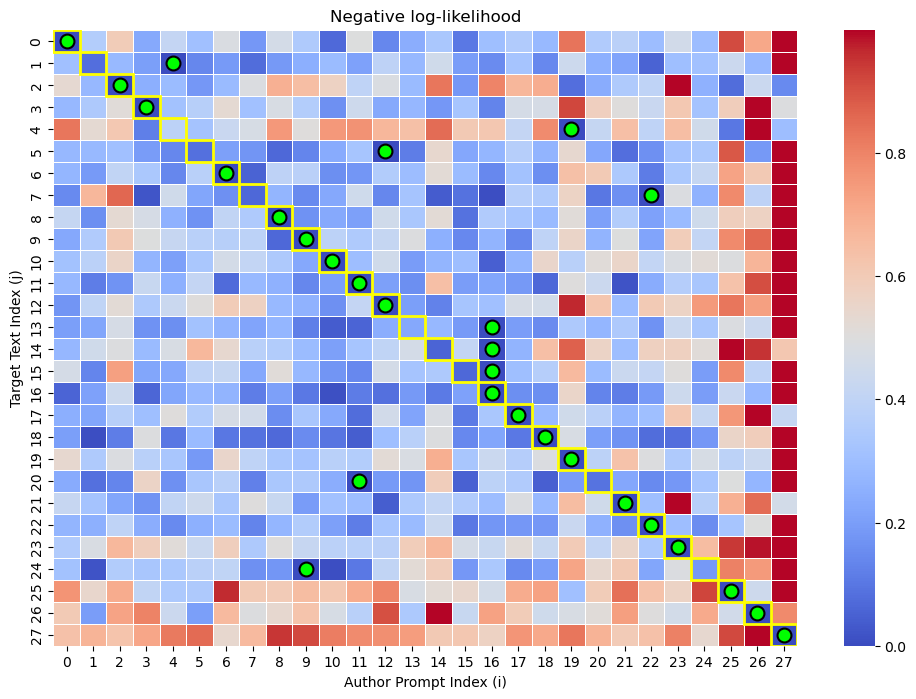

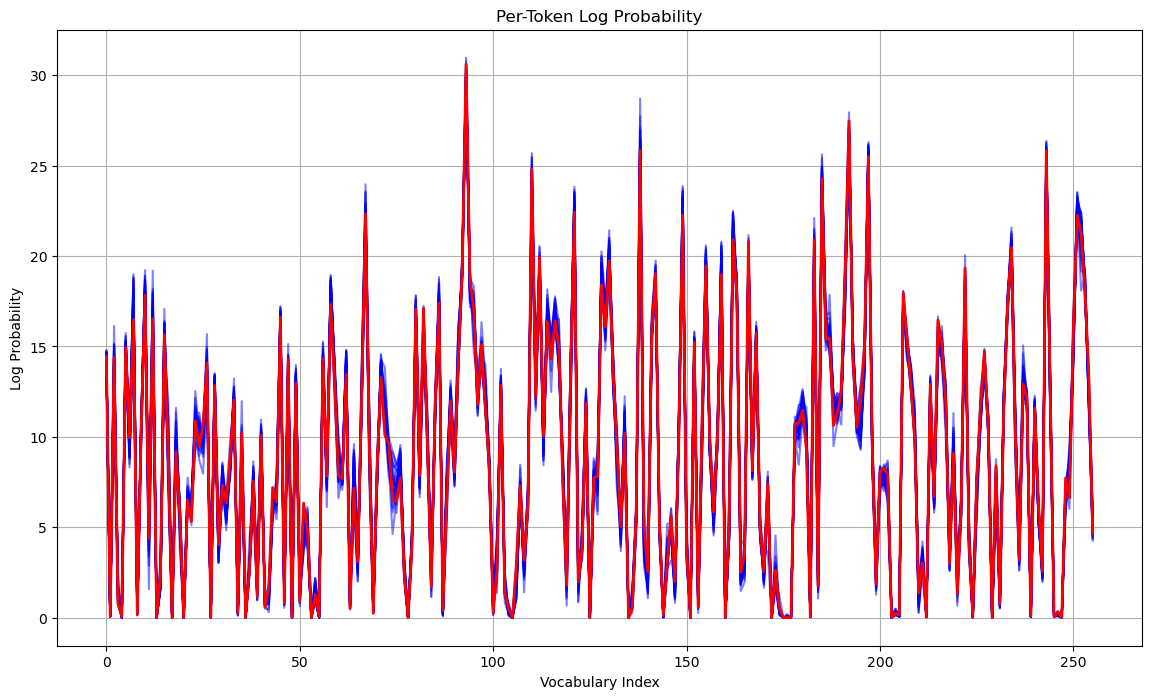

In [17]:
import torch.nn.functional as F
import torch
import math
import numpy as np

# Clear cache and IPC handles at the start
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

def score_target_text_batch(model, encoder_input_ids, decoder_start_token, target_ids, max_length=64):
    batch_size = encoder_input_ids.shape[0]
    decoder_input_ids = decoder_start_token.unsqueeze(0).expand(batch_size, 1)  # [batch_size, 1]
    
    neg_log_likelihoods = torch.zeros(batch_size, device=encoder_input_ids.device)
    per_token_log_probs = torch.zeros(batch_size, max_length, device=encoder_input_ids.device)
    
    target_len = min(target_ids.shape[1], max_length)
    
    # Wrap inference in no_grad context to save memory
    with torch.no_grad():
        for i in range(target_len):
            logits, _ = model(encoder_input_ids, decoder_input_ids)
            logits = logits[:, -1, :]
            log_probs = F.log_softmax(logits, dim=-1)
            
            next_target_token = target_ids[:, i]
            token_log_probs = log_probs.gather(1, next_target_token.unsqueeze(1)).squeeze(1)
            token_nll = -token_log_probs
            per_token_log_probs[:, i] = token_nll
            neg_log_likelihoods += token_nll
            
            decoder_input_ids = torch.cat((decoder_input_ids, next_target_token.unsqueeze(1)), dim=1)
    
    return neg_log_likelihoods, per_token_log_probs

# Assuming tokenizer, model, device, and preprocessed_data are defined
decoder_start_token = torch.tensor([tokenizer.pad_token_id], device=device)

max_length = 256
num_samples = len(preprocessed_data)

log_probs_matrix = np.zeros((num_samples, num_samples))
log_probs_per_token = np.zeros((num_samples, num_samples, max_length))

# You might need to adjust the batch size here if processing all num_samples at once is too heavy.
batch_size = 10  # Example smaller batch size for authors

for i in range(num_samples):
    _, sentence_tensor_target = preprocessed_data[i]
    sentence_tensor_target = sentence_tensor_target.to(device)
    print(i, tokenizer.decode(sentence_tensor_target.tolist()[:10]))
    
    # Process authors in smaller batches if needed
    all_authors = []
    for j in range(num_samples):
        author_tensor, _ = preprocessed_data[j]
        all_authors.append(author_tensor.to(device))
    
    # Process in batches
    nlls = []
    token_probs = []
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        authors_batch = torch.stack(all_authors[start:end], dim=0)
        target_batch = sentence_tensor_target.unsqueeze(0).expand(authors_batch.shape[0], -1)
        
        nll_batch, per_token_batch = score_target_text_batch(
            model,
            authors_batch,
            decoder_start_token,
            target_batch,
            max_length=max_length
        )
        
        nlls.append(nll_batch.detach().cpu().numpy())
        token_probs.append(per_token_batch.detach().cpu().numpy())
        
        # Optionally clear cache after processing a batch
        del authors_batch, target_batch, nll_batch, per_token_batch
        torch.cuda.empty_cache()
        print(f"Processed batch {start}:{end}")
    nll_full = np.concatenate(nlls)
    token_probs_full = np.concatenate(token_probs, axis=0)
    
    log_probs_matrix[i, :] = nll_full
    log_probs_per_token[i, :nll_full.shape[0], :] = token_probs_full

print(log_probs_matrix)
plot_heat(log_probs_matrix)
plot_per_token_prob(log_probs_per_token, 4, figsize_=(14, 8))
np.save('data/log_probs_matrix.npy', log_probs_matrix)
np.save('data/log_probs_per_token.npy', log_probs_per_token)

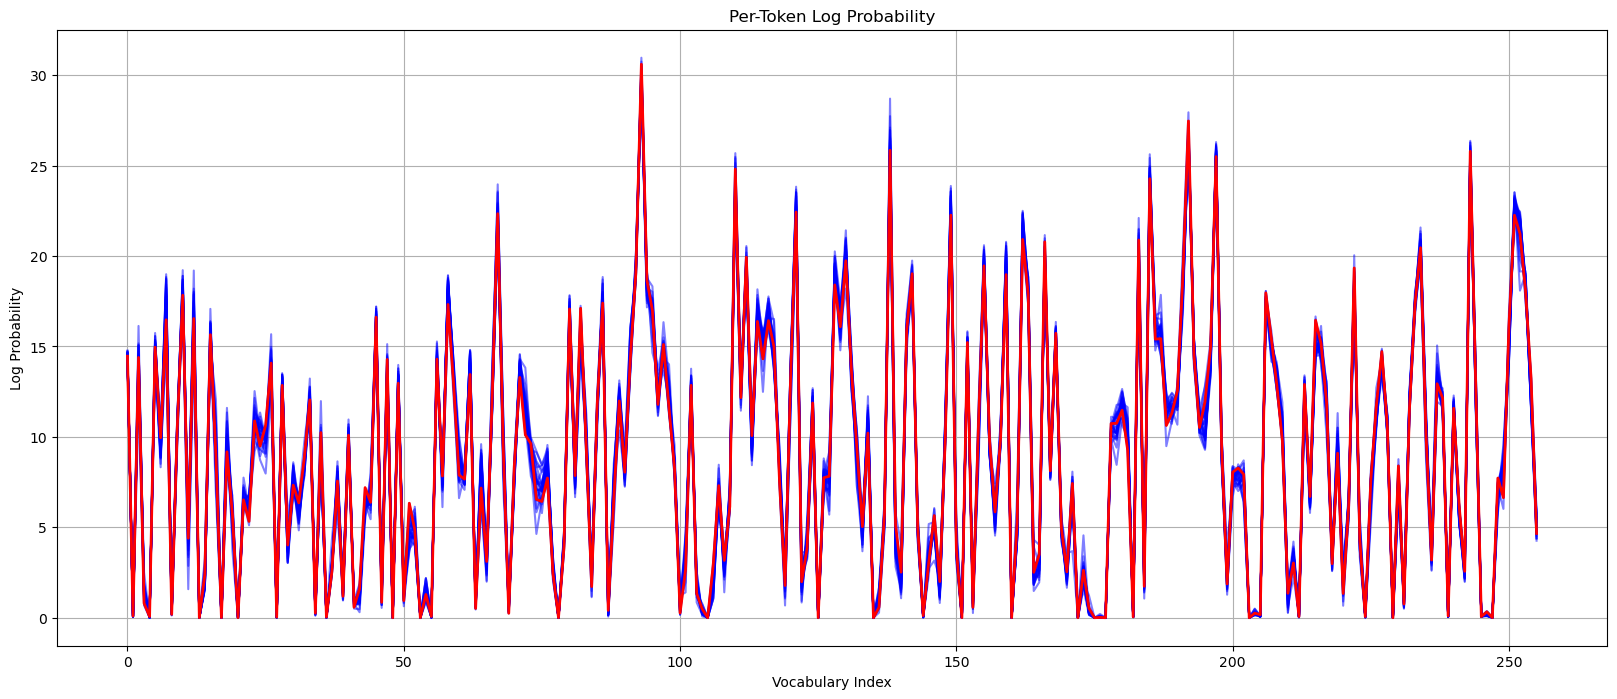

In [32]:
plot_per_token_prob(log_probs_per_token,4, figsize_=(20, 8))

0 En ce moment neuf heures sonnèrent à
Processed batch 0:10
Processed batch 10:20
Processed batch 20:30
1 After a long hesitation, I have quite decided
Processed batch 0:10
Processed batch 10:20
Processed batch 20:30
2 [Illustration] "We will repos
Processed batch 0:10
Processed batch 10:20
Processed batch 20:30
3 We are not hostile._ There was quiet on
Processed batch 0:10
Processed batch 10:20
Processed batch 20:30
4 "Douglass--ah, you
Processed batch 0:10
Processed batch 10:20
Processed batch 20:30
5 During the meal small pieces of roots of
Processed batch 0:10
Processed batch 10:20
Processed batch 20:30
6 What he needed, right now, but bad
Processed batch 0:10
Processed batch 10:20
Processed batch 20:30
7 Their cathedral stood in urgent need of repairs. It
Processed batch 0:10
Processed batch 10:20
Processed batch 20:30
8 Yet withal there was a sense of long
Processed batch 0:10
Processed batch 10:20
Processed batch 20:30
9 "Ods fish, Madam, are
Processed batch 0:10
Processed batch

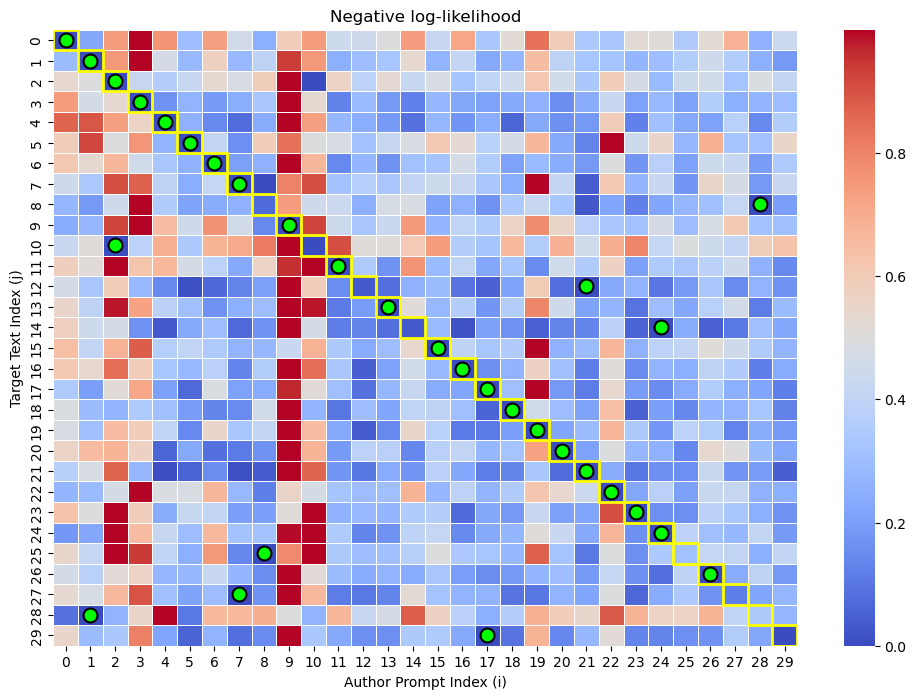

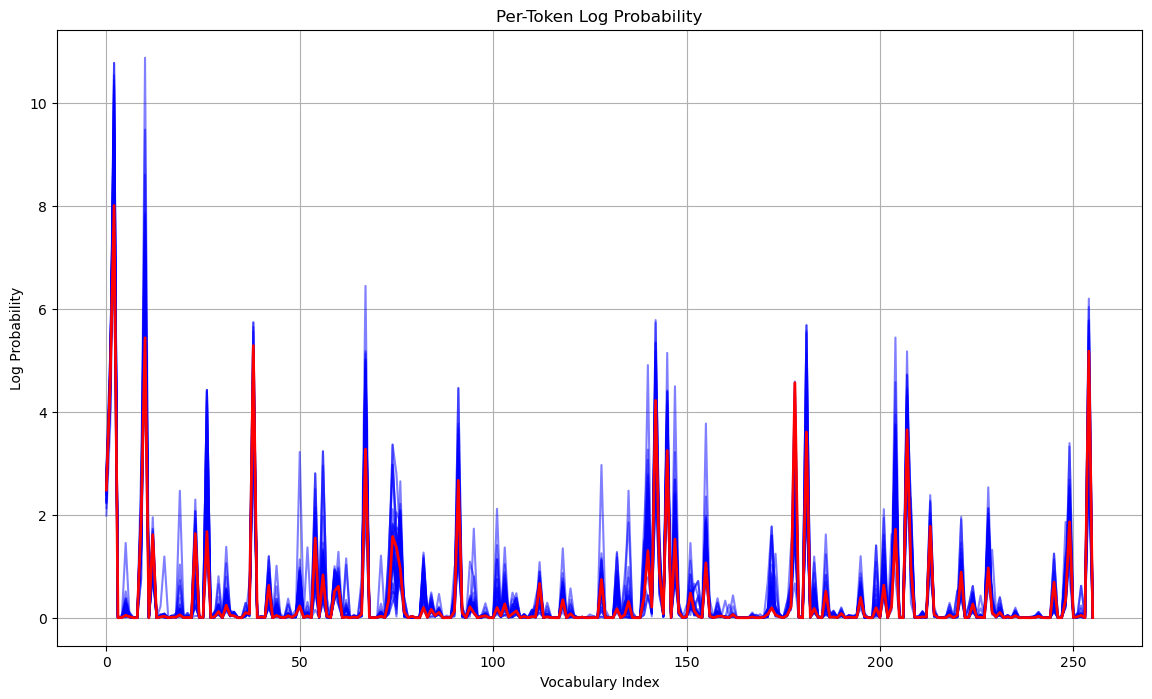

In [18]:
import torch.nn.functional as F
import torch
import math
import numpy as np

# Clear cache and IPC handles at the start
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

def score_target_text_batch(model, encoder_input_ids, decoder_start_token, target_ids, max_length=64):
    batch_size = encoder_input_ids.shape[0]
    decoder_input_ids = decoder_start_token.unsqueeze(0).expand(batch_size, 1)  # [batch_size, 1]
    
    neg_log_likelihoods = torch.zeros(batch_size, device=encoder_input_ids.device)
    per_token_log_probs = torch.zeros(batch_size, max_length, device=encoder_input_ids.device)
    
    target_len = min(target_ids.shape[1], max_length)
    
    # Wrap inference in no_grad context to save memory
    with torch.no_grad():
        for i in range(target_len):
            logits, _ = model(encoder_input_ids, decoder_input_ids)
            logits = logits[:, -1, :]
            log_probs = F.log_softmax(logits, dim=-1)
            
            next_target_token = target_ids[:, i]
            token_log_probs = log_probs.gather(1, next_target_token.unsqueeze(1)).squeeze(1)
            token_nll = -token_log_probs
            per_token_log_probs[:, i] = token_nll
            neg_log_likelihoods += token_nll
            
            decoder_input_ids = torch.cat((decoder_input_ids, next_target_token.unsqueeze(1)), dim=1)
    
    return neg_log_likelihoods, per_token_log_probs

# Assuming tokenizer, model, device, and preprocessed_data are defined
decoder_start_token = torch.tensor([tokenizer.pad_token_id], device=device)

max_length = 256
num_samples = 30

log_probs_matrix_ = np.zeros((num_samples, num_samples))
log_probs_per_token_ = np.zeros((num_samples, num_samples, max_length))

# You might need to adjust the batch size here if processing all num_samples at once is too heavy.
batch_size = 10  # Example smaller batch size for authors
data_ = preprocessed_testing_data
for i in range(num_samples):
    _, sentence_tensor_target = data_[i]
    sentence_tensor_target = sentence_tensor_target.to(device)
    print(i, tokenizer.decode(sentence_tensor_target.tolist()[:10]))
    
    # Process authors in smaller batches if needed
    all_authors = []
    for j in range(num_samples):
        author_tensor, _ = data_[j]
        all_authors.append(author_tensor.to(device))
    
    # Process in batches
    nlls = []
    token_probs = []
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        authors_batch = torch.stack(all_authors[start:end], dim=0)
        target_batch = sentence_tensor_target.unsqueeze(0).expand(authors_batch.shape[0], -1)
        
        nll_batch, per_token_batch = score_target_text_batch(
            model,
            authors_batch,
            decoder_start_token,
            target_batch,
            max_length=max_length
        )
        
        nlls.append(nll_batch.detach().cpu().numpy())
        token_probs.append(per_token_batch.detach().cpu().numpy())
        
        # Optionally clear cache after processing a batch
        del authors_batch, target_batch, nll_batch, per_token_batch
        torch.cuda.empty_cache()
        print(f"Processed batch {start}:{end}")
    nll_full = np.concatenate(nlls)
    token_probs_full = np.concatenate(token_probs, axis=0)
    
    log_probs_matrix_[i, :] = nll_full
    log_probs_per_token_[i, :nll_full.shape[0], :] = token_probs_full

print(log_probs_matrix_)
plot_heat(log_probs_matrix_)
plot_per_token_prob(log_probs_per_token_,4, figsize_=(14, 8))
np.save('data/log_probs_matrix_.npy', log_probs_matrix_)
np.save('data/log_probs_per_token_.npy', log_probs_per_token_)

Give also the first couple of tokens (~64)

0 En ce moment neuf heures sonnèrent à
1 After a long hesitation, I have quite decided
2 [Illustration] "We will repos
3 We are not hostile._ There was quiet on
4 "Douglass--ah, you
5 During the meal small pieces of roots of
6 What he needed, right now, but bad
7 Their cathedral stood in urgent need of repairs. It
8 Yet withal there was a sense of long
9 "Ods fish, Madam, are
10 [Illustration: FIG. 4.-
11 Is it observed beyond the limits of a
12 RUSTIC HOUSES.] RUS
13 But the problem was academic, for Dennison saw
14 Not a man answered. In the sull
15 'Yar's what I call Wolf
16 Me, of these Nor skilled nor studious,
17 Perhaps he ought to close it. But
18 One of them was a Little, Small,
19 And he'd have to stand up to
20 The coroner, the doctor, the clerk
21 John, I love!" She saw the half-
22 "Here is the note," he concluded
23 My first discovery made, however, during the black
24 "And what happens?" Dr. Peccary
25 Has the medicine done your back good? My back
26 "I'd like to have he

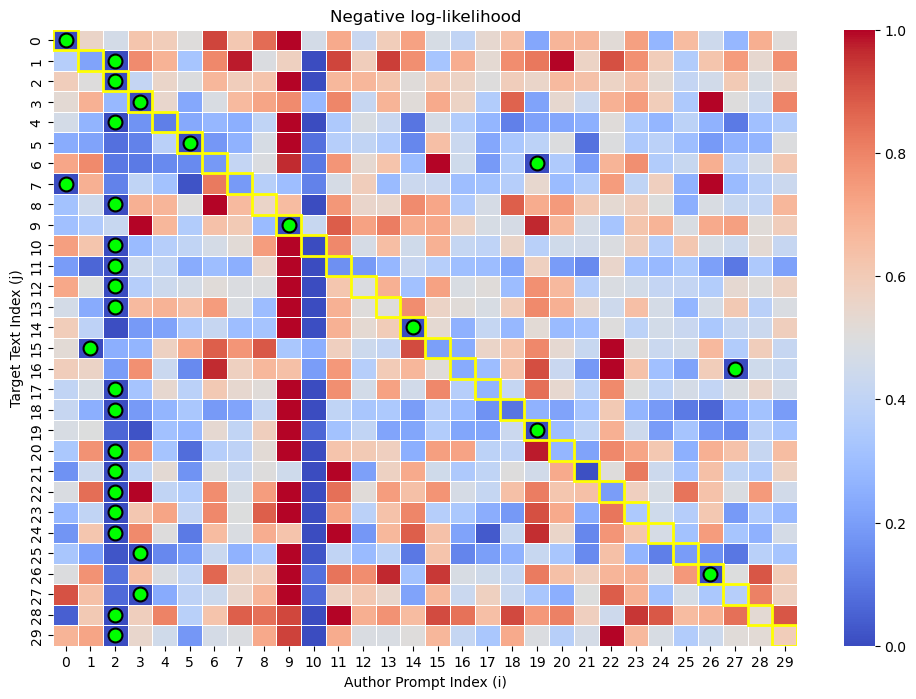

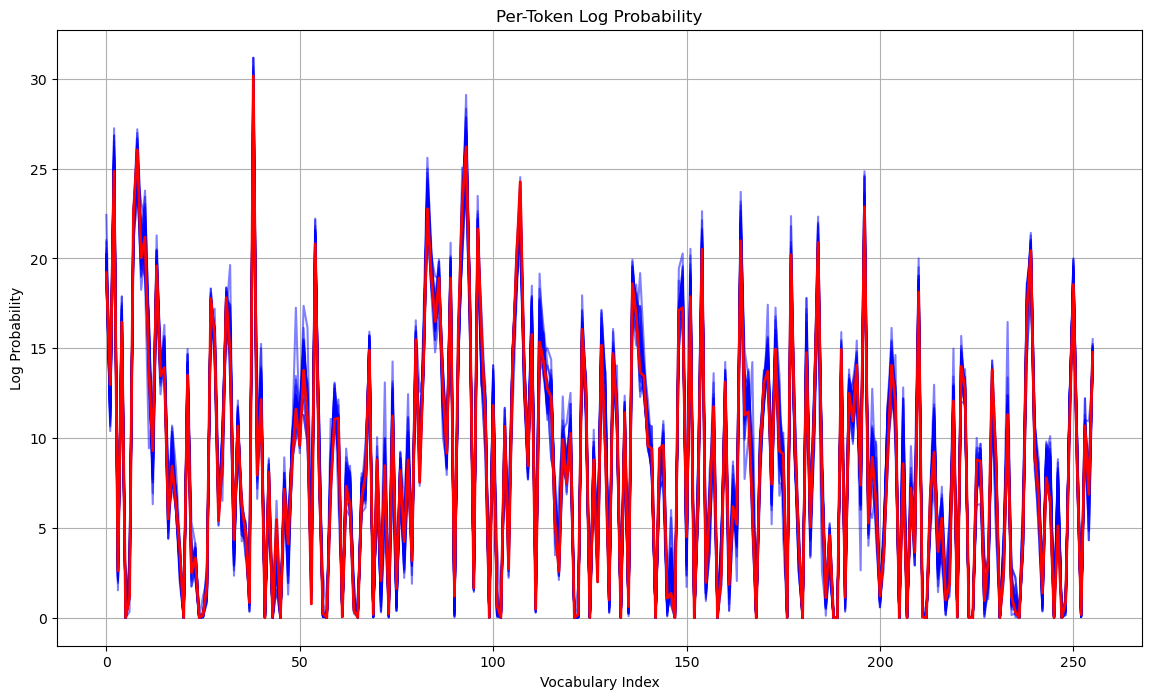

In [ ]:
import torch.nn.functional as F
import torch
import math
import numpy as np

# Clear cache and IPC handles at the start
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

def score_target_text_batch(model, encoder_input_ids, decoder_start_tokens, target_ids, max_length=64):
    batch_size = encoder_input_ids.shape[0]
    decoder_input_ids = decoder_start_tokens.unsqueeze(0).expand(batch_size, decoder_start_tokens.shape[0])  # [batch_size, 1]
    
    neg_log_likelihoods = torch.zeros(batch_size, device=encoder_input_ids.device)
    per_token_log_probs = torch.zeros(batch_size, max_length, device=encoder_input_ids.device)
    
    target_len = min(target_ids.shape[1], max_length)
    
    # Wrap inference in no_grad context to save memory
    with torch.no_grad():
        for i in range(target_len):
            logits, _ = model(encoder_input_ids, decoder_input_ids)
            logits = logits[:, -1, :]
            log_probs = F.log_softmax(logits, dim=-1)
            
            next_target_token = target_ids[:, i]
            token_log_probs = log_probs.gather(1, next_target_token.unsqueeze(1)).squeeze(1)
            token_nll = -token_log_probs
            per_token_log_probs[:, i] = token_nll
            neg_log_likelihoods += token_nll
            
            decoder_input_ids = torch.cat((decoder_input_ids, next_target_token.unsqueeze(1)), dim=1)
    
    return neg_log_likelihoods, per_token_log_probs

# Assuming tokenizer, model, device, and preprocessed_data are defined
decoder_start_token = torch.tensor([tokenizer.pad_token_id], device=device)

max_length = 256
num_samples = len(preprocessed_testing_data)

log_probs_matrix__ = np.zeros((num_samples, num_samples))
log_probs_per_token__= np.zeros((num_samples, num_samples, max_length))

# You might need to adjust the batch size here if processing all num_samples at once is too heavy.
batch_size = 12  # Example smaller batch size for authors
data_ = preprocessed_testing_data
for i in range(num_samples):
    _, sentence_tensor_target = data_[i]
    sentence_tensor_target = sentence_tensor_target.to(device)
    print(i, tokenizer.decode(sentence_tensor_target.tolist()[:10]))
    sentence_tensor_target = sentence_tensor_target[64:]
    sentence_tensor_author = sentence_tensor_target[:64]
    # Process authors in smaller batches if needed
    all_authors = []
    for j in range(num_samples):
        author_tensor, _ = data_[j]
        all_authors.append(author_tensor.to(device))
    
    # Process in batches
    nlls = []
    token_probs = []
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        authors_batch = torch.stack(all_authors[start:end], dim=0)
        target_batch = sentence_tensor_target.unsqueeze(0).expand(authors_batch.shape[0], -1)
        decoder_input = decoder_start_token + sentence_tensor_author
        nll_batch, per_token_batch = score_target_text_batch(
            model,
            authors_batch,
            decoder_input.to(device),
            target_batch,
            max_length=max_length
        )
        
        nlls.append(nll_batch.detach().cpu().numpy())
        token_probs.append(per_token_batch.detach().cpu().numpy())
        
        # Optionally clear cache after processing a batch
        del authors_batch, target_batch, nll_batch, per_token_batch
        torch.cuda.empty_cache()
    nll_full = np.concatenate(nlls)
    token_probs_full = np.concatenate(token_probs, axis=0)
    log_probs_matrix__[i, :] = nll_full
    log_probs_per_token__[i, :nll_full.shape[0], :] = token_probs_full

print(log_probs_matrix__)
plot_heat(log_probs_matrix__)
plot_per_token_prob(log_probs_per_token__,4, figsize_=(14, 8))
np.save('data/log_probs_matrix__.npy', log_probs_matrix__)
np.save('data/log_probs_per_token__.npy', log_probs_per_token__)

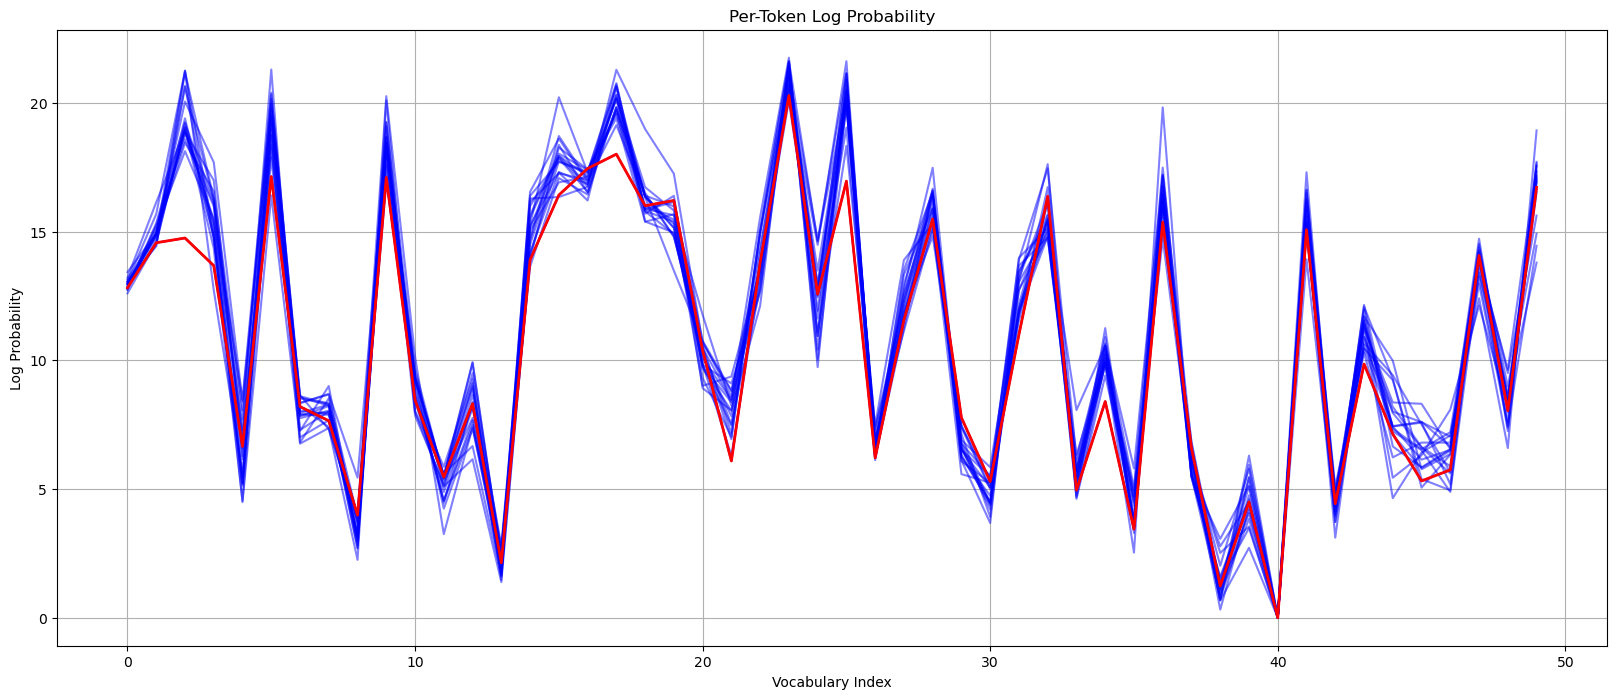

In [53]:
plot_per_token_prob(log_probs_per_token__,2, figsize_=(20, 8))

Generate Text and Attribute

0 <pad>Most of F. Brand--Ex
torch.Size([1])
torch.Size([1])
Processed batch 0:12
torch.Size([1])
torch.Size([1])
Processed batch 12:24
torch.Size([1])
torch.Size([1])
Processed batch 24:30
1 <pad>"No, no!" I tried stern
torch.Size([1])
torch.Size([1])
Processed batch 0:12
torch.Size([1])
torch.Size([1])
Processed batch 12:24
torch.Size([1])
torch.Size([1])
Processed batch 24:30
2 <pad>Yet, the process of what is known.
torch.Size([1])
torch.Size([1])
Processed batch 0:12
torch.Size([1])
torch.Size([1])
Processed batch 12:24
torch.Size([1])
torch.Size([1])
Processed batch 24:30
3 <pad>What Dusky Bay most abounds
torch.Size([1])
torch.Size([1])
Processed batch 0:12
torch.Size([1])
torch.Size([1])
Processed batch 12:24
torch.Size([1])
torch.Size([1])
Processed batch 24:30
4 <pad>The Mr. Beans--The "
torch.Size([1])
torch.Size([1])
Processed batch 0:12
torch.Size([1])
torch.Size([1])
Processed batch 12:24
torch.Size([1])
torch.Size([1])
Processed batch 24:30
5 <pad>So then they burned up a

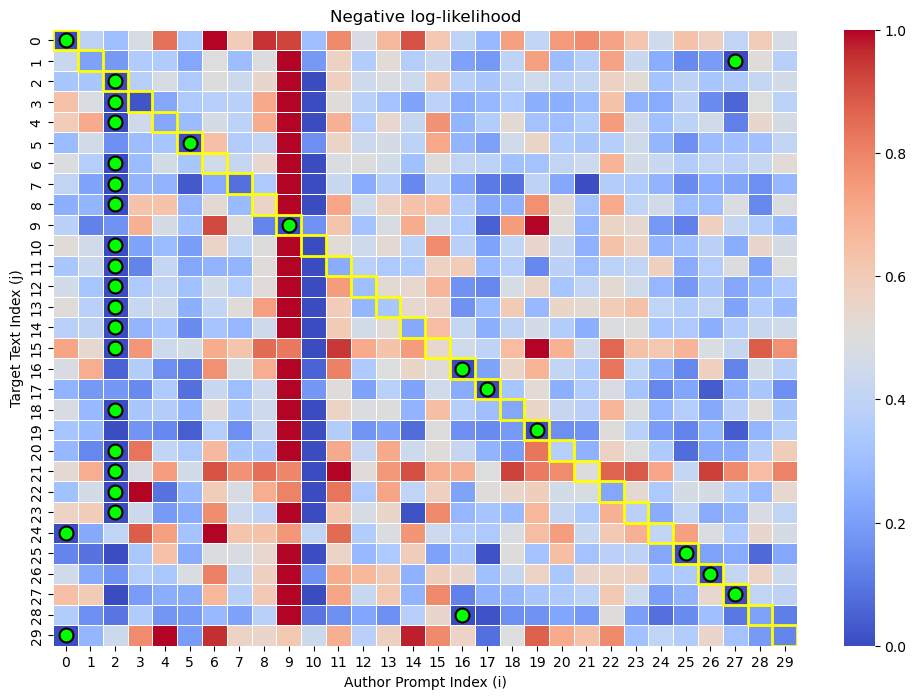

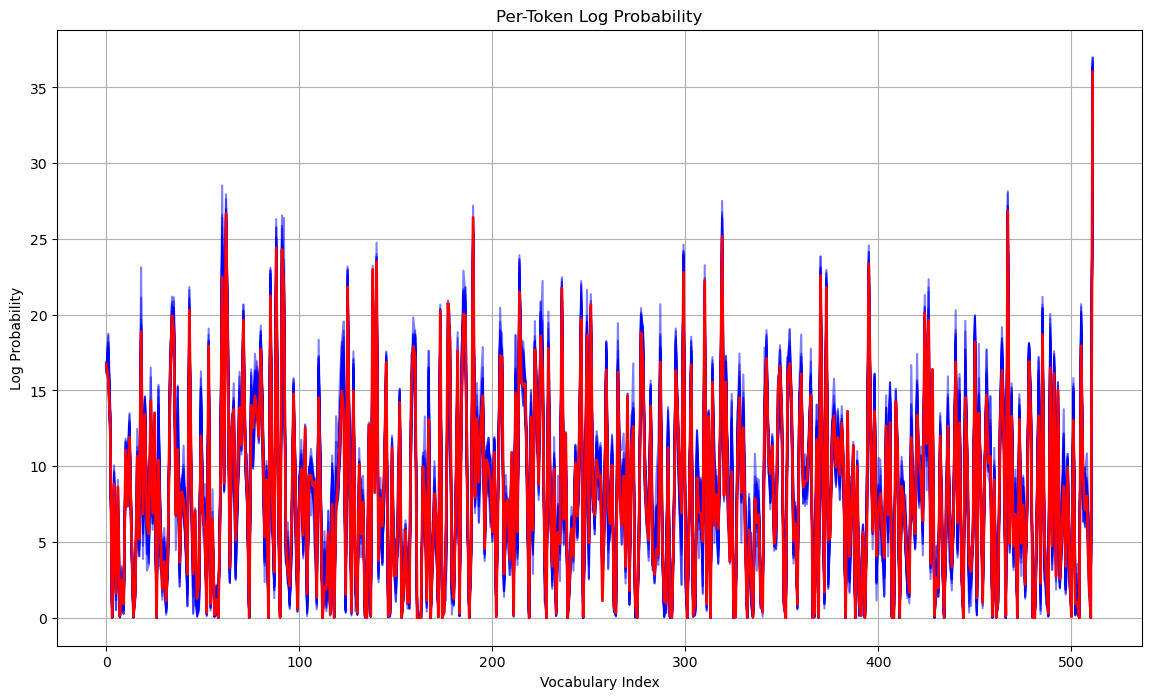

In [33]:
# Assuming tokenizer, model, device, and preprocessed_data are defined
decoder_start_token = torch.tensor([tokenizer.pad_token_id], device=device)

max_length = 512
num_samples = 30

log_probs_matrix___ = np.zeros((num_samples, num_samples))
log_probs_per_token___= np.zeros((num_samples, num_samples, max_length))

# You might need to adjust the batch size here if processing all num_samples at once is too heavy.
batch_size = 12  # Example smaller batch size for authors
data_ = preprocessed_testing_data
for i in range(num_samples):
    author_target, sentence_tensor_target = data_[i]
    sentence_tensor_target = model.generate(
        author_target.unsqueeze(0).to(device),
        decoder_start_token,
        max_length
    )
    print(i, tokenizer.decode(sentence_tensor_target[0].tolist()[:10]))
    sentence_tensor_target = sentence_tensor_target.to(device)
    all_authors = []
    for j in range(num_samples):
        author_tensor, _ = data_[j]
        all_authors.append(author_tensor.to(device))
    
    # Process in batches
    nlls = []
    token_probs = []
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        authors_batch = torch.stack(all_authors[start:end], dim=0)
        target_batch = sentence_tensor_target[0].unsqueeze(0).expand(authors_batch.shape[0], -1)
        print(decoder_start_token.shape)
        decoder_input = decoder_start_token 
        print(decoder_input.shape)
        nll_batch, per_token_batch = score_target_text_batch(
            model,
            authors_batch,
            decoder_start_token,
            target_batch,
            max_length=max_length
        )
        
        nlls.append(nll_batch.detach().cpu().numpy())
        token_probs.append(per_token_batch.detach().cpu().numpy())
        
        # Optionally clear cache after processing a batch
        del authors_batch, target_batch, nll_batch, per_token_batch
        torch.cuda.empty_cache()
        print(f"Processed batch {start}:{end}")
    nll_full = np.concatenate(nlls)
    token_probs_full = np.concatenate(token_probs, axis=0)
    
    log_probs_matrix___[i, :] = nll_full
    log_probs_per_token___[i, :nll_full.shape[0], :] = token_probs_full

print(log_probs_matrix___)
plot_heat(log_probs_matrix___)
plot_per_token_prob(log_probs_per_token___,4, figsize_=(14, 8))
np.save('data/log_probs_matrix___.npy', log_probs_matrix___)
np.save('data/log_probs_per_token___.npy', log_probs_per_token___)


In [50]:
print(tokenizer.decode(preprocessed_testing_data[2][0].tolist()))
#print("\n".join(tokenizer.decode(t[0].tolist()) for t in preprocessed_testing_data[:20]))
print(to_test_df.loc[:20,['Count', 'Author']])

Various</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
    Count                             Author
0      64                    Alexandre Dumas
1      13                         Eugène Sue
2     232                            Various
3      32                      Mack Reynolds
4       8               Jr. John W. Campbell
5       2                 Paul B. Du Chaillu
6      68                      H. Beam Piper
7       4                 Reginald R. Sharpe
8      26                 Charlotte M. Yonge
10     83  Baron Edward Bulwer Lytton Lytton
11    232                            Various
12      3              Fannie Hardy Eckstorm
13      3           Albert Frederick Siepert
14     36                    Robert Sheckley
15      6                 F. Marion Crawford
16     31             Edward Sylvester Ellis
17      3       Sir Walter Alexander Raleigh
18      4                        John Blaine
19      9                   

In [ ]:
max_length = 256
num_samples = 20
log_probs_matrix = np.zeros((num_samples, num_samples))
log_probs_per_token = np.zeros((num_samples, num_samples, max_length))
for i in range(num_samples):
    author_tensor, sentence_tensor_target = preprocessed_testing_data[i]
    sentence_tensor_target.to(device)
    print(i, tokenizer.decode(sentence_tensor_target.tolist()[:10]))
    for j in range(num_samples):
        author_tensor, sentence_tensor = preprocessed_testing_data[j]
        author_tensor = author_tensor.to(device)
        log_probs_matrix[i, j], log_probs_per_token[i,j] = score_target_text(model, author_tensor.unsqueeze(0).to(device), decoder_start_token, sentence_tensor_target.unsqueeze(0).to(device), max_length=max_length)
print(log_probs_matrix)
plot_heat(log_probs_matrix)

In [ ]:
log_probs_matrix = np.zeros((batch_size, batch_size))
x, y = get_batch_tensor_testing(batch_size)
print(x.size(), y.size())
for i in range(batch_size):
    for j in range(batch_size):
        x_ = x[i].unsqueeze(0).clone().detach().to(device)
        y_ = y[j].unsqueeze(0).clone().detach().to(device) 
        print(x_.size(), y_.size())
        print(x_)
        log_probs_matrix[i, j] = compute_log_probability(model, x_, y_)
        print((enc.decode(x_[0].tolist())))
        print((enc.decode(y_[0].tolist())))
        print(log_probs_matrix[0,0])
        break
    break
log_probs_matrix

Decoder Model trained on middle of text 

In [69]:
model_dec, checkpoint = load_decoder('models/lm_48_resume_middle_text_end.pth')
model_args = checkpoint['model_args']
model_dec.eval()
model_dec.to(device)
model_args

/tmp/ipykernel_6766/2464915221.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"{model_name}", map_location=device)


{'n_layer': 12,
 'n_head': 12,
 'n_embd': 768,
 'block_size': 48,
 'bias': False,
 'vocab_size': 100278,
 'dropout': 0.0}

In [66]:
import re
dec_df_ = df__
dec_test_df = to_test_df
def middle_text(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    sentences = sentences[int(len(sentences)/3):]
    sentences = " ".join(sentences)
    return sentences

dec_df_['Text'] = dec_df_['Text'].apply(middle_text)
dec_df_
dec_test_df['Text'] = dec_test_df['Text'].apply(middle_text)
dec_test_df

/tmp/ipykernel_6766/2943587200.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_test_df['Text'] = dec_test_df['Text'].apply(middle_text)


,Author,Text,Count,ID
0,Alexandre Dumas,En ce moment neuf heures sonnèrent à l'église ...,64,852
1,Eugène Sue,"After a long hesitation, I have quite decided....",13,692
2,Various,"[Illustration] ""We will repose awhile,"" _Mr. P...",232,376
3,Mack Reynolds,We are not hostile._ There was quiet on the br...,32,11305
4,Jr. John W. Campbell,"""Douglass--ah, you're through. Get on the trai...",8,9463
...,...,...,...,...
63,Beatrix Potter,This pig went to market; This pig stayed at ho...,36,213
64,Allen Chapman,Only a radio set which could be dismantled and...,12,4960
65,Andrew Fetler,"""What are you waiting for, man?"" Charlie said....",4,13116
66,Georg Ebers,"""'That is his blood!"" she thought with anguish...",162,777


En ce moment neuf heures sonnèrent
After a long hesitation, I have quite decided.
[Illustration] "We will repose
We are not hostile._ There was quiet on the
"Douglass--ah, you're through.
[[0.35499619 1.21767623 1.11648293 1.43508964 1.47338212]
 [2.16595311 1.07222458 1.9036571  2.21906164 1.98940218]
 [1.62140087 1.10632462 0.39815984 0.99248501 0.92986994]
 [4.8555681  4.98249542 4.6649758  3.86292787 4.45241589]
 [4.08697807 4.09838722 3.47531764 3.50409462 2.41277931]]


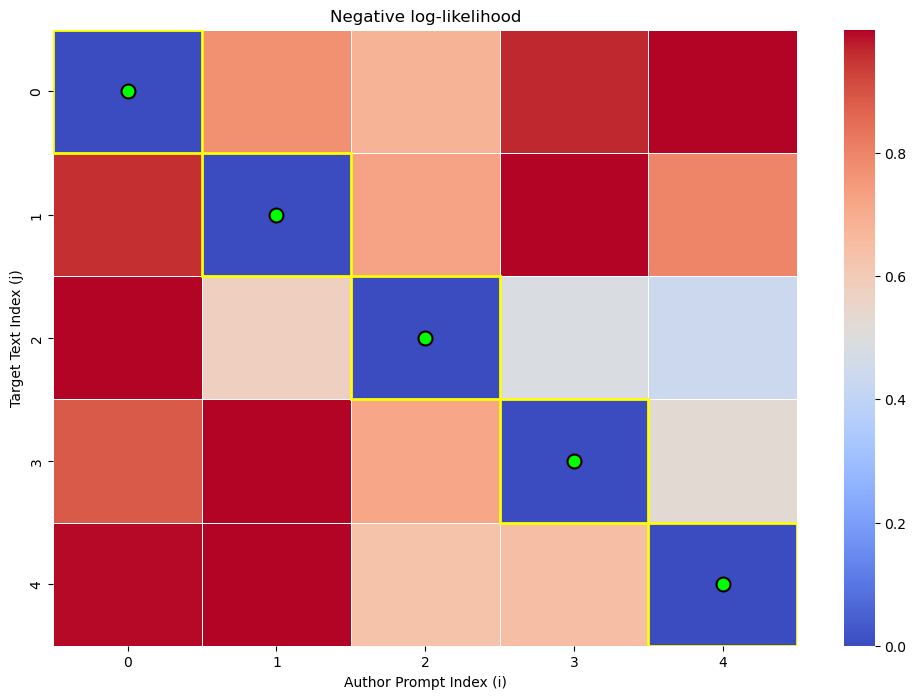

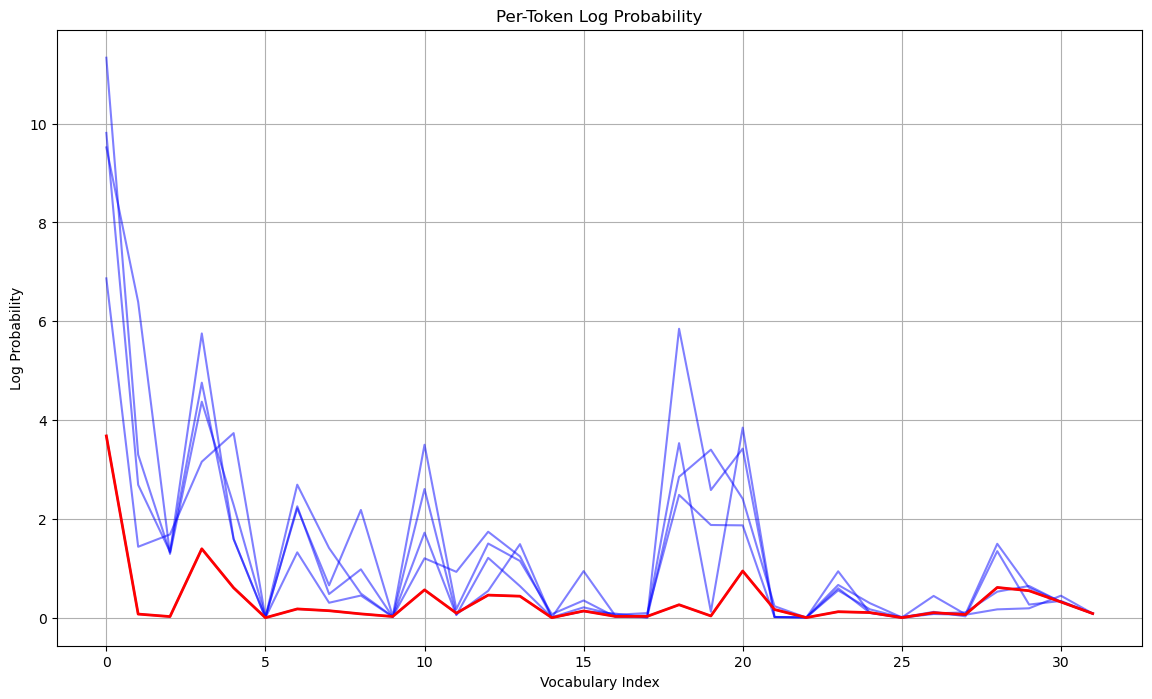

In [70]:
max_length = 32
num_samples = 5
import tiktoken
enc = tiktoken.encoding_for_model('gpt-4')
log_probs_matrix= np.zeros((num_samples, num_samples))
log_probs_per_token = np.zeros((num_samples, num_samples, max_length))
normalization_factor = 1
for k in range(normalization_factor):
    for j in range(num_samples):
        target_text = dec_test_df.iloc[j]['Text']
        ids = enc.encode_ordinary(target_text)
        print(enc.decode(ids[:10]))
        for i in range(0, num_samples):
            author = dec_test_df.iloc[i]['Author']
            prompt = author
            prompt = str(prompt) + '<|endofprompt|>'
            author_prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
            target_text_enc = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
            author_prompt = torch.tensor(author_prompt, dtype=torch.long).unsqueeze(0).to(device)
            probs, probs_ = compute_log_probability(model_dec, author_prompt, target_text_enc, max_length=max_length)
            log_probs_matrix[j, i] += probs
            log_probs_per_token[j, i, :] = probs_
    
log_probs_matrix /= normalization_factor
print(log_probs_matrix)
plot_heat(log_probs_matrix)
plot_per_token_prob(log_probs_per_token, 0, figsize_=(14, 8))

In [ ]:
model_16, checkpoint_16 = load_model(f"models/lm_16_resume_indices_end.pth")
model_16.eval()
model_16.to(device)
print(model_16.config)
print('done')

In [ ]:
block_size = 16
author = 'Various'
prompt = atoi[str(author)]
prompt = str(prompt) + '<|endofprompt|>'
prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
prompt = torch.tensor([prompt])  # Ensure it's a tensor
prompt = prompt.to(device)
p, t = log_probability_gen(model_16, prompt)
log_prob = compute_log_probability(model_16, prompt, torch.tensor([t[2:]], dtype=torch.long).to(device))
print(log_prob)

print(enc.decode(t))
text_generated = enc.decode(t)
plt.figure(figsize=(7, 5))
plt.plot(p, marker='o')
plt.title('Log Probability Values')
plt.xlabel('Index')
plt.ylabel('Log Probability')
plt.grid(True)
plt.show()

In [ ]:
device = 'cuda'
def generate_text(prompt, max_new_tokens=20, encoded=False):
    # Encode the prompt and convert it to a tensor
    if not encoded:
        prompt = enc.encode(prompt)
        prompt = prompt + enc.encode('<|endofprompt|>', allowed_special={'<|endofprompt|>'})
    context = torch.tensor(prompt, dtype=torch.long).unsqueeze(0).to(device)
    generated_ids = model_16.generate(context, max_new_tokens=max_new_tokens)[0].tolist()
    generated_text = enc.decode(generated_ids)
    # Decode the generated indices to text
    return generated_text

for i in range(5):
    prompt = atoi[str(df.iloc[i]['Author'])]
    prompt = str(prompt) + '<|endofprompt|>'
    prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
    print(enc.decode(prompt), df.iloc[i]['Text'][:100])
    generated_text = generate_text(prompt, max_new_tokens=64, encoded=True)
    print(f"generated text: \n{generated_text} ")
    print('-------------------')

In [ ]:
df_authors = df.groupby('Author')
i,j,k = 0,0,0
for author, group in df_authors:
    print(author, len(group))
    if len(group) >=1:
        for i in range(len(group)):
            prompt = atoi[str(author)]
            prompt = str(prompt) + '<|endofprompt|>'
            prompt = enc.encode(prompt, allowed_special={'<|endofprompt|>'})
            print(enc.decode(prompt), group.iloc[i]['Text'][:100])
            generated_text = generate_text(prompt, max_new_tokens=64, encoded=True)
            print(f"generated text: \n{generated_text} ")
            print('-------------------')
    break


In [ ]:

arr = np.memmap('data/data_author_names.bin', dtype=np.float32, mode='r')
offsets = np.load("/itet-stor/kbayraktar/net_scratch/training_ml/data/author_names_offsets.npy")
reconstructed_tensors = [arr[offsets[i]:offsets[i+1]] for i in range(len(offsets)-1)]

train_memmap, test_memmap = train_test_split(reconstructed_tensors, test_size=0.005, random_state=42)
print(f"train memmap shape: {len(train_memmap)}, test memmap shape: {len(test_memmap)}")

In [ ]:
len(test_memmap)
test_memmap[3].shape

In [ ]:
test_memmap

In [ ]:
enc.decode(test_memmap[0].astype(np.int64).tolist())
testing_data = test_memmap[0].astype(np.int64)
testing_data

In [ ]:
testing_data = []
for i in range(len(test_memmap)):
    testing_data.append(test_memmap[i].astype(np.int64).tolist())
len(testing_data[0])
type(testing_data)

In [ ]:
for i in range(len(testing_data)):
    print(enc.decode(testing_data[i][:64]))

In [ ]:
df___ = df.drop_duplicates(subset=['Author'], keep='first')
df___.shape

In [ ]:
enc._special_tokens

In [ ]:
import pandas as pd

# Define the split token
split_token = 100276  # This represents <|endofprompt|>

# Process each entry in testing_data
data_split = []
for tokens in testing_data:
    if split_token in tokens:
        split_index = tokens.index(split_token)
        author_tokens = tokens[:split_index]
        text_tokens = tokens[split_index + 1:]

        author = enc.decode(author_tokens).strip()
        text = enc.decode(text_tokens).strip()

        data_split.append([author, text])
    else:
        # If no split token is found, put everything in the text column
        text = enc.decode(tokens).strip()
        data_split.append(["Unknown", text])

# Create DataFrame
testing_df = pd.DataFrame(data_split, columns=["Author", "Text"])

testing_df


In [ ]:
testing_df['Author'].value_counts()
len(testing_df.loc[:1,'Text'])
len(testing_df.iloc[0]['Text'])
testing_df.iloc[0]['Text']

In [ ]:
len(set(df_['Author'].unique()).intersection(set(testing_df['Author'].unique())))

Playground Data preprocessing to train on middle of book data. Sentences splitting was done locally on my machine with nltk... didn't get nltk to work on cluster... todo

In [ ]:
tt = torch.load('data/author_sentence_pairs.pt')
tt.shape

In [ ]:
tt.shape

In [ ]:
import random
while True:
    rs = 413
    as_train, as_test = train_test_split(tt, test_size=0.5, random_state=rs)
    as_train.shape, as_test.shape
    as_test_list = as_test.tolist()
    split_token = 100276  # This represents <|endofprompt|>

    # Process each entry in testing_data
    data_split = []
    for tokens in as_test_list:
        if split_token in tokens:
            split_index = tokens.index(split_token)
            author_tokens = tokens[:split_index]
            text_tokens = tokens[split_index + 1:]
            assert len(author_tokens)+len(text_tokens)+1 == 1024

            author = enc.decode(author_tokens).strip()
            text = enc.decode(text_tokens).strip()

            data_split.append([author, text])
        else:
            print('tt')
            # If no split token is found, put everything in the text column
            text = enc.decode(tokens).strip()
            data_split.append(["Unknown", text])
    # Create DataFrame
    testing_df = pd.DataFrame(data_split, columns=["Author", "Text"])

    as_train_list = as_train.tolist()
    data_split = []
    for tokens in as_train_list:
        if split_token in tokens:
            split_index = tokens.index(split_token)
            author_tokens = tokens[:split_index]
            text_tokens = tokens[split_index + 1:]
            assert len(author_tokens)+len(text_tokens)+1 == 1024
            author = enc.decode(author_tokens).strip()
            text = enc.decode(text_tokens).strip()

            data_split.append([author, text])
        else:
            print('tt')
            # If no split token is found, put everything in the text column
            text = enc.decode(tokens).strip()
            data_split.append(["Unknown", text])
    
    training_df = pd.DataFrame(data_split, columns=["Author", "Text"])
    testing_df

    print(len(set(testing_df['Author'].unique()).intersection(set(df_['Author'].unique()))), rs)
    if len(set(testing_df['Author'].unique()).intersection(set(df_['Author'].unique()))) >= 25:
        print(len(set(testing_df['Author'].unique()).intersection(set(df_['Author'].unique()))), rs)
        break

In [ ]:
training_df

In [ ]:
testing_df

In [ ]:
rs = 413

In [ ]:
len(testing_df['Author'].unique())
overlapping_authors = set(testing_df['Author'].unique()).intersection(set(df_['Author'].unique()))
overlapping_authors

In [ ]:
len(tt)*0.005

In [ ]:
len(tt)

In [ ]:
testing_df_ = testing_df.drop_duplicates(subset=['Author'], keep='first')

# Get all other duplicate occurrences
df_duplicates = testing_df[testing_df.duplicated(subset=['Author'], keep='first')]


In [ ]:
testing_df_.shape, df_duplicates.shape

In [ ]:
len(testing_df_['Author'].unique()) == testing_df_.shape[0]

In [ ]:
testing_df_ = testing_df_.drop_duplicates(subset=['Author'], keep='first')
print(testing_df_.shape)
overlap_df = testing_df_.loc[testing_df['Author'].isin(overlapping_authors)]
print(overlap_df.shape)
rest_df = testing_df_.loc[~testing_df_['Author'].isin(overlapping_authors)]
print(rest_df.shape)
ot_train, ot_test = train_test_split(rest_df, test_size=0.02, random_state=rs)
#rest_df_ = rest_df.sample(n=int(len(tt)*0.005-overlap_df.shape[0]), random_state=rs)
tt_testing_df = pd.concat([overlap_df, ot_test])
print(ot_test.shape, tt_testing_df.shape)
tt_testing_df

In [ ]:
len(enc.encode(tt_testing_df.iloc[0]['Author'])) + len(enc.encode(tt_testing_df.iloc[0]['Text'], allowed_special={'<|endoftext|>'}))
tt_testing_df.iloc[0]['Text']

In [ ]:
def clean_text(text):
    if isinstance(text, str):  # Ensure it's a string before processing
        text = text.split('<|endoftext|>')[0]  # Keep only text before '<|endoftext|>'
        text = text.rstrip('0')  # Remove trailing zeros
    return text
tt_testing_df['Text'] = tt_testing_df['Text'].apply(clean_text)
tt_testing_df.iloc[2]['Text']

In [ ]:

tt_train = pd.concat([training_df, ot_train, df_duplicates])
tt_train

In [ ]:
tt_train['Text'] = tt_train['Text'].apply(clean_text)
tt_train.iloc[2]['Text']

In [ ]:
train_tensors = tt_train.apply(lambda x: (enc.encode(str(x['Author'])) + [eop_token] + enc.encode(str(x['Text'])) + [enc.eot_token]), axis=1)
train_tensors

In [ ]:
type(train_tensors)
len(train_tensors.tolist()[4])
len((train_tensors.tolist()[4]))
enc.decode(train_tensors.tolist()[4])   

In [ ]:
import torch
type(train_tensors)
type(train_tensors.tolist())
len(train_tensors.tolist())
train_tensor_list = train_tensors.tolist()
print(len(train_tensor_list))
len(train_tensor_list[3])
type(train_tensor_list[3])



In [ ]:
flattened_np = np.concatenate([np.int64(x) for x in train_tensor_list])
print(len(flattened_np))

offsets = np.cumsum([0] + [len(x) for x in train_tensor_list[:-1]])
offsets
print(len(offsets))

filename = "data/as_train_array.bin"
arr = np.memmap(filename, dtype=np.float32, mode='w+', shape=(len(flattened_np),))
arr[:] = flattened_np[:]
arr.flush()
np.save("data/as_train_offset", offsets)

In [ ]:
arr = np.memmap("data/as_train_array.bin", dtype=np.float32, mode='r')
offsets = np.load("data/as_train_offset.npy")
indices_tensor = [arr[offsets[i]:offsets[i+1]] for i in range(len(offsets)-1)]
len(indices_tensor)
len(offsets)
indices_tensor[0].shape

In [ ]:
indices_tensor = [list(np.array(mmap, dtype=int)) for mmap in indices_tensor]


In [ ]:
len(indices_tensor)
type(indices_tensor[4])

In [ ]:
enc.decode(indices_tensor[0])

In [ ]:
testing_df.shape

Batch Loader for author sentence pairs

In [ ]:
device = 'cuda'
block_size = 512
batch_size = 32
def get_batch_pairs(split):
    if split=='train':
        data = indices_tensor
    else:
        data = test_memmap
    ix = torch.randint(len(data), (1,))
    data = data[ix]
    print(len(data))
    if len(data) < block_size:
        data = np.concatenate(( np.zeros(block_size - len(data) +3), data))
    ix = torch.randint(1, len(data) - block_size-1, (batch_size-1,))
    ix = np.concatenate(([0], ix))
    x = torch.stack([torch.tensor(data[i:i+block_size]) for i in ix])
    y = torch.stack([torch.tensor(data[i+1:i+1+block_size]) for i in ix])
    if device=='cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x,y

x,y = get_batch_pairs('train')
x

In [ ]:
enc.decode(x[0].tolist())

In [ ]:
train_bin = np.memmap('data/train.bin', dtype=np.uint16, mode='r')
len(train_bin)
print(train_bin[:64])
enc_2.decode(train_bin[:300000])

In [ ]:
import re

def middle_text(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    sentences = sentences[int(len(sentences)/3):]
    sentences = " ".join(sentences)
    return sentences

texts = df.loc[:3,'Text'].apply(middle_text)

In [ ]:
texts

Decoder Data Middle of text: Take author and text starting from middle of text until the end , each batch I take one book which is basically author and middle of Texas until the end and split that up into blocks, train test split has 25 of the authors which are in sample.CSV and 30 others


In [ ]:
eop_token

In [ ]:
example = (train_memmap[0].astype(np.int64).tolist())
split_index = example.index(eop_token)
author_tokens = example[:split_index]
text_tokens = example[split_index + 1:]
print(len(author_tokens), len(text_tokens))
import re

def middle_text(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    sentences = sentences[int(len(sentences)/3):]
    sentences = " ".join(sentences)
    return sentences

text = ((enc.encode(middle_text(enc.decode(text_tokens)), allowed_special={'<|endoftext|>'})))
print(author_tokens)
print(enc.decode(author_tokens))
data_ = enc.encode(itoa[int(enc.decode(author_tokens))]) + [eop_token] + text 



In [ ]:
import numpy as np
import torch
import concurrent.futures

def process_example(i):
    # Convert the memmap element to a list of int64 values.
    example = i.astype(np.int64).tolist()
    
    # Split the example by the eop_token.
    split_index = example.index(eop_token)
    author_tokens = example[:split_index]
    text_tokens = example[split_index + 1:]
    
    # Process the text tokens.
    text = enc.encode(middle_text(enc.decode(text_tokens)), allowed_special={'<|endoftext|>'})
    
    # Process the author tokens.
    data_ = enc.encode(itoa[int(enc.decode(author_tokens))]) + [eop_token] + text
    
    # Pad to length 512 if needed.
    if len(data_) < 512:
        # Optionally print the length for debugging (remove in production).
        print(len(data_))
        data_ = np.concatenate((np.zeros(512 - len(data_)), data_))
    print('done')
    # Create a tensor.
    data_tensor = torch.tensor(data_, dtype=torch.long)
    return data_tensor

# Adjust max_workers to the number of CPU cores you can use.
with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    # Map the processing function to the list.
    train_tensors_middle_text = list(executor.map(process_example, train_memmap))

# Check the length to verify that all elements were processed.
print(len(train_tensors_middle_text))


Encoder Data

Split into Author Sentence Pairs

Tokenize with t5 tokenizer

In [ ]:
example = (train_memmap[0].astype(np.int64).tolist())
split_index = example.index(eop_token)
author_tokens = example[:split_index]
text_tokens = example[split_index + 1:]
print(len(author_tokens), len(text_tokens))
import re

def middle_text(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    start_sentences = sentences[int(len(sentences)/3):int(len(sentences)/2)]
    start_sentences = " ".join(start_sentences)
    end_sentences = sentences[int(len(sentences)/2):]
    end_sentences = " ".join(end_sentences)
    return start_sentences, end_sentences

text_start = ((enc.encode(middle_text(enc.decode(text_tokens))[0])))
text_end = ((enc.encode(middle_text(enc.decode(text_tokens))[1], allowed_special={'<|endoftext|>'})))
print(author_tokens)
print(enc.decode(author_tokens))
data_ = enc.encode(str(atoi[str(enc.decode(author_tokens))])) + [eop_token] + text_start+[enc.eot_token]
print(data_)
print(len(data_))
data_ = enc.encode(str(atoi[str(enc.decode(author_tokens))])) + [eop_token] + text_end
print(data_)
print(len(data_))

In [ ]:
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
tokenizer('Hello, this is a test')

In [ ]:
import tiktoken
enc = tiktoken.encoding_for_model('gpt-4')
tokenizer(enc.decode(data_))

In [ ]:
tokenizer(enc.decode(data_[:10]))

In [ ]:

author_seq_len = 24  # or another value depending on your requirements
sentence_seq_len = 512

preprocessed_data = []
for idx, row in df_.iterrows():
    author = row['Author']
    text = row['Text']
    
    # Tokenize the author text; adjust max_length as needed.
    author_tokens = tokenizer.encode(
        author,
        truncation=True,
        padding='max_length',
        max_length=author_seq_len
    )
    
    # Tokenize the sentence text and ensure it is regulated to 512 tokens.
    sentence_tokens = tokenizer.encode(
        text,
        truncation=True,
        padding='max_length',
        max_length=sentence_seq_len
    )
    
    # Convert lists to tensors.
    author_tensor = torch.tensor(author_tokens, dtype=torch.long)
    sentence_tensor = torch.tensor(sentence_tokens, dtype=torch.long)
    
    # Append the tuple.
    preprocessed_data.append((author_tensor, sentence_tensor))



len(preprocessed_data[0])

In [ ]:
len(preprocessed_data[0][1])

In [ ]:


# Optionally, save the preprocessed data for later use:
#torch.save(preprocessed_data, 'preprocessed_data.pt')


import numpy as np
import torch
import concurrent.futures
def middle_text(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    start_sentences = sentences[int(len(sentences)/3):]
    start_sentences = " ".join(start_sentences)
    return start_sentences
def process_example(i):
    # Convert the memmap element to a list of int64 values.
    example = i.astype(np.int64).tolist()
    
    # Split the example by the eop_token.
    split_index = example.index(eop_token)
    author_tokens = example[:split_index]
    text_tokens = example[split_index + 1:]
    author_decoded = enc.decode(author_tokens)
    
    author_tokens = tokenizer.encode(
        author_decoded,
        truncation=True,
        padding='max_length',
        max_length=author_seq_len
    )
    # Process the text tokens.
    text = middle_text(enc.decode(text_tokens))
    sentence_tokens = tokenizer.encode(
        text,
        truncation=True,
        padding='max_length',
        max_length=sentence_seq_len
    )
    
    # Convert lists to tensors.
    author_tensor = torch.tensor(author_tokens, dtype=torch.long)
    sentence_tensor = torch.tensor(sentence_tokens, dtype=torch.long)
    print('done')
    return (author_tensor, sentence_tensor)

# Adjust max_workers to the number of CPU cores you can use.
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    # Map the processing function to the list.
    train_tensors_enc = list(executor.map(process_example, train_memmap))

# Check the length to verify that all elements were processed.
print(len(train_tensors_enc))


In [ ]:
len(train_tensors_enc[0][0])
tokenizer.decode(train_tensors_enc[9][0])

In [ ]:


# Optionally, save the preprocessed data for later use:
#torch.save(preprocessed_data, 'preprocessed_data.pt')


import numpy as np
import torch
import concurrent.futures
def middle_text(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    start_sentences = sentences[int(len(sentences)/3):]
    start_sentences = " ".join(start_sentences)
    return start_sentences
def process_example(i):
    # Convert the memmap element to a list of int64 values.
    example = i.astype(np.int64).tolist()
    
    # Split the example by the eop_token.
    split_index = example.index(eop_token)
    author_tokens = example[:split_index]
    text_tokens = example[split_index + 1:]
    author_decoded = enc.decode(author_tokens)
    
    author_tokens = tokenizer.encode(
        author_decoded,
        truncation=True,
        padding='max_length',
        max_length=author_seq_len
    )
    # Process the text tokens.
    text = enc.decode(text_tokens)
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    start_sentences = sentences[int(len(sentences)/3):]
    start_sentences = " ".join(start_sentences)

    sentence_tokens = tokenizer.encode(
        start_sentences,
        truncation=True,
        padding='max_length',
        max_length=sentence_seq_len
    )
    
    # Convert lists to tensors.
    author_tensor = torch.tensor(author_tokens, dtype=torch.long)
    sentence_tensor = torch.tensor(sentence_tokens, dtype=torch.long)
    print('done')
    return (author_tensor, sentence_tensor)

# Adjust max_workers to the number of CPU cores you can use.
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    # Map the processing function to the list.
    test_tensors_enc = list(executor.map(process_example, test_memmap))

# Check the length to verify that all elements were processed.
print(len(test_tensors_enc))


In [ ]:
torch.save(train_tensors_enc, 'data/train_tensors_enc.pt')
torch.save(test_tensors_enc, 'data/test_tensors_enc.pt')

In [ ]:
for i in range(len(train_tensors_enc)):
    assert len(train_tensors_enc[i][0]) == author_seq_len
    assert len(train_tensors_enc[i][1]) == sentence_seq_len

In [ ]:
train_ = torch.load('data/train_tensors_enc.pt')
train_[0][1].shape

In [ ]:
type(train_tensors_middle_text)

In [ ]:
assert False
for j, i in enumerate(train_memmap):
    example = i.astype(np.int64).tolist()
    split_index = example.index(eop_token)
    author_tokens = example[:split_index]
    text_tokens = example[split_index + 1:]
    text = ((enc.encode(middle_text(enc.decode(text_tokens)), allowed_special={'<|endoftext|>'})))
    data_ = enc.encode(itoa[int(enc.decode(author_tokens))]) + [eop_token] + text 
    data_tensor = torch.tensor(data_, dtype=torch.long)
    if len(data_) <512:
        print(len(data_))
        data_ = np.concatenate(( np.zeros(512 - len(data_)), data_))
        data_tensor = torch.tensor(data_, dtype=torch.long)
    
    print(j)
    
len(train_tensors_middle_text)

In [ ]:
import torch

# Later, load the list back into memory
train_tensors_middle_text = torch.load('data/train_tensors_middle_text.pt')
print(len(train_tensors_middle_text))
type(train_tensors_middle_text[0])
enc.decode(train_tensors_middle_text[10].tolist())


In [ ]:
enc.decode(train_tensors_middle_text[0].tolist())

In [ ]:
test_tensors_middle_text = []
for j,i in enumerate(test_memmap):
    example = i.astype(np.int64).tolist()
    split_index = example.index(eop_token)
    author_tokens = example[:split_index]
    text_tokens = example[split_index + 1:]
    text = ((enc.encode(middle_text(enc.decode(text_tokens)), allowed_special={'<|endoftext|>'})))
    data_ = enc.encode(itoa[int(enc.decode(author_tokens))]) + [eop_token] + text 
    data_tensor = torch.tensor(data_, dtype=torch.long)
    if len(data_) >512:
        print(data_tensor.shape)
    print(j)
    test_tensors_middle_text.append(data_tensor)
    
len(test_tensors_middle_text)

In [ ]:
import torch

# Save the list of tensors to a file
torch.save(test_tensors_middle_text, 'test_tensors_middle_text.pt')

# Later, load the list back into memory
test_tensors_middle_text = torch.load('test_tensors_middle_text.pt')
print(len(test_tensors_middle_text))
type(test_tensors_middle_text[0])


In [ ]:
test_tensors_middle_text[0]

In [ ]:
device_type= 'cuda'
batch_size = 32
def get_batch_tensor(split):
    if split=='train':
        data = train_tensors_middle_text
    else:
        data = test_memmap
    ix = torch.randint(len(data), (1,))
    data = data[ix]
    ix = torch.randint(1, len(data) - block_size-1, (batch_size-1,))
    ix = np.concatenate(([0], ix))
    x = torch.stack([data[i:i+block_size] for i in ix])
    print(x.size())
    y = torch.stack([data[i+1:i+1+block_size] for i in ix])
    if device_type=='cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x,y
get_batch_tensor('train')